In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
models_path = home_dir + '/models/'
import sys
sys.path.append(module_path)
fig_dir = 'figures/'
bp_network_dir = home_dir + '/trained_networks/backprop_trained/'
import time
import importlib
from collections import Counter
import random
import tensorflow as tf
import pandas as pd
from keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, LeakyReLU, concatenate
from keras.callbacks import EarlyStopping, TerminateOnNaN
from loading_datasets import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
#import model_management
from scipy.special import comb
import multiprocessing as mp
import datetime
import codecs, json
import corner
import pickle
from itertools import combinations
%load_ext autoreload
%autoreload 1
%aimport data_processing
%aimport multiprocessing_modules
%aimport plotting
%aimport model_setup
from data_processing import *
from multiprocessing_modules import train_net, init
from plotting import *
from model_setup import *

np.random.seed(999)
random.seed(999)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
### Run on CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = ""

### Set parameter string

In [ ]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_lossFunc_%s_nTrainSamples_%d_nEpochs_%d_batchSize_%d' % (
    nLayers, neuronsPerLayer, activationFunction, loss_function, train_size, nEpochs, batchSize)
print(param_string)

In [ ]:
print(np.mean(y_test_norm, 0))
print(np.std(y_test_norm, 0))
print(np.min(x_test_norm, 0))
print(np.max(x_test_norm, 0))

In [ ]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

In [ ]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

In [ ]:
a = '{:.1e}'.format(2.4e7)
print(a)

### Load an existing model

In [ ]:
model_name = '6x6_all-points_redshifts00-01-02-05-10-20-30-40-60-80_tanh_Halo_mass-Halo_mass_peak-Scale_peak_mass-Scale_half_mass-Halo_growth_rate-Redshift_to_Stellar_mass-SFR_test_score5.91e-06'
model = load_model(bp_network_dir + model_name + '/model.h5')
training_data_dict = pickle.load(open(bp_network_dir + model_name + '/training_data_dict.p', 'rb'))

### Get the standard pictures

In [17]:
mode = 'test' # 'train', 'val, 'test'

norm_scores = model.evaluate(x=training_data_dict['input_test_dict'], y=training_data_dict['output_test_dict'],
                                               sample_weight=training_data_dict['test_weights'], verbose=1)
tot_score = norm_scores[0]
predicted_points = predict_points(model, training_data_dict, data_type = mode, original_units=True)
title = 'Inputs: {}\n{:.1e} train points, test mse {:.3e}, {} data'.format(', '.join(input_features), len(training_data_dict['train_indices']), tot_score, mode)

20000/20000 [==============================] - 2s 83us/step


In [18]:
### Standard plots
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title, data_type=mode,
                                   predicted_points = predicted_points)
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
fig3 = get_halo_stellar_mass_plots(model, training_data_dict, unit_dict, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)
fig4 = get_stellar_mass_sfr_plots(model, training_data_dict, unit_dict, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)
fig5 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
plt.show

NameError: name 'unit_dict' is not defined

<function matplotlib.pyplot.show(*args, **kw)>

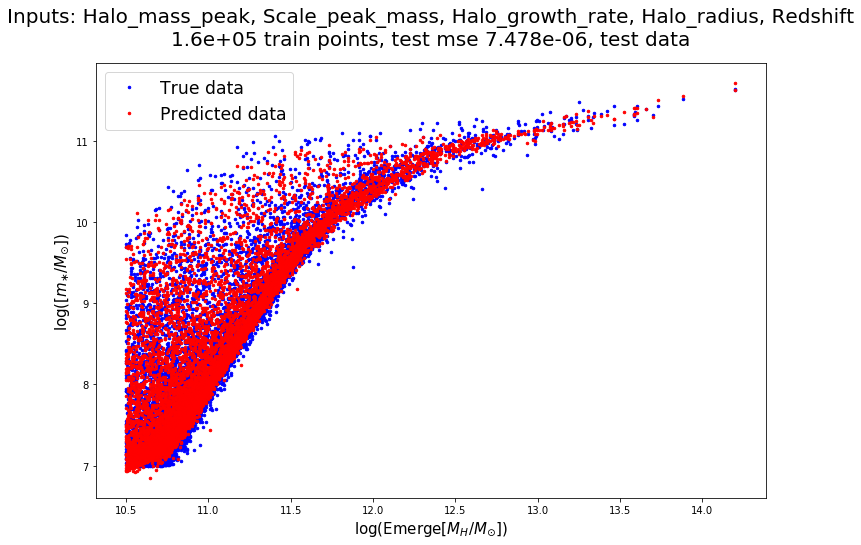

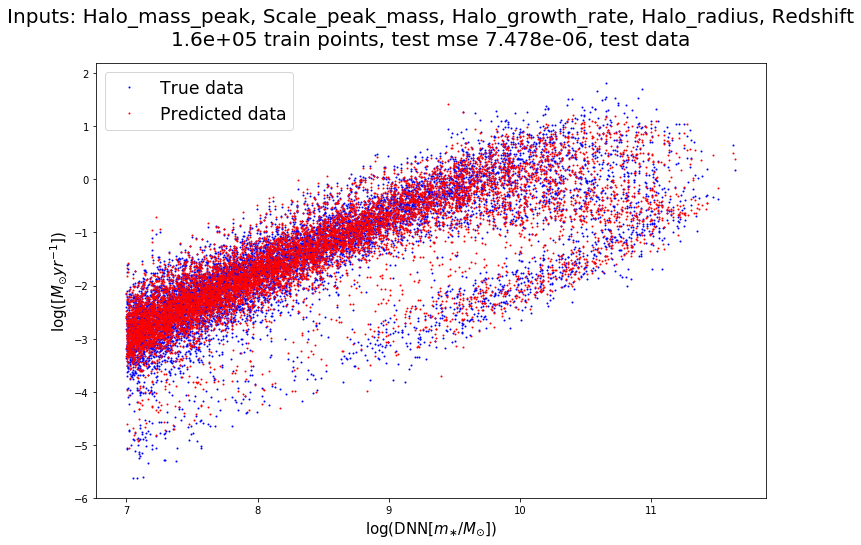

In [23]:
fig6 = get_real_vs_pred_same_fig(model, training_data_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'Stellar_mass', title=title, data_type=mode, marker_size=5, predicted_points=predicted_points,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
fig7 = get_real_vs_pred_same_fig(model, training_data_dict, x_axis_feature='Stellar_mass', 
                                 y_axis_feature = 'SFR', title=title, data_type=mode, marker_size=2, predicted_points=predicted_points,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
plt.show

In [ ]:
fig8, fig9 = get_sfr_stellar_mass_contour(model, training_data_dict, unit_dict, title=None, data_type='test',
                                 y_min=None, y_max=None, x_min=None, x_max=None, predicted_points=predicted_points)

In [21]:
for redshift in redshifts:
    fig88 = get_real_obs_plot(model, training_data_dict, redshift=redshift, title=title, data_type=mode, full_range=True)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
### Save the figures
date_string = datetime.datetime.now().strftime('%H-%M_%Y-%m-%d')
fig1.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_true_pred_sfr_scatter.png', bbox_inches = 'tight')
fig2.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) + '_boxplot_stellar_mass.png', bbox_inches = 'tight')
fig3.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_scatter_comp_halo_vs_stellar_mass.png', bbox_inches = 'tight')
fig4.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_boxplot_sfr.png', bbox_inches = 'tight')
fig5.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_scatter_comp_stellar_mass_vs_sfr.png', bbox_inches = 'tight')

### Save model

In [33]:
redshift_string = '-'.join(['{:02.0f}'.format(red*10) for red in redshifts])
if tot_nr_points == 'all':
    nr_points_string = 'all-points'
else:
    nr_points_string = '{:.1e}points'.format(tot_nr_points)
network_name = '{:d}x{:d}_{}_redshifts{}_{}_{}_to_{}_test_score{:.2e}'.format(
    nr_hidden_layers, nr_neurons_per_layer, nr_points_string, redshift_string, activation_function, '-'.join(input_features), '-'.join(output_features),
    tot_score
)
print(network_name)

os.makedirs(os.path.dirname(bp_network_dir + network_name + '/model.h5'), exist_ok=True)

model.save(bp_network_dir + network_name + '/model.h5')
pickle.dump(training_data_dict, open(bp_network_dir + network_name + '/training_data_dict.p', 'wb'))
# save the position in weight space for the pso algorithm to use as starting point
model_weights = model.get_weights()
position = []
for weight_matrix in model_weights:
    position.extend(np.ndarray.flatten(weight_matrix))
position = np.array(position)

pickle.dump(position, open(bp_network_dir + network_name + '/best_position.p', 'wb'))

8x8_2.0e+05points_redshifts00-01-02-05-10_tanh_Halo_mass_peak-Scale_peak_mass-Halo_growth_rate-Halo_radius-Redshift_to_Stellar_mass-SFR_test_score7.48e-06


### Set model parameters

In [29]:
### General parameters
nr_steps = 5e4
nr_repetitions = 1
tot_nr_points = 2e5 # how many examples will be used for training+validation+testing, 'all' or a number
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1
batch_size = 2.5e4
norm = {'input': 'zero_mean_unit_std',
        'output': 'none'} # 'none',   'zero_mean_unit_std',   'zero_to_one'
input_features = ['Halo_mass_peak', 'Scale_peak_mass', 'Halo_growth_rate', 'Halo_radius', 'Redshift']
output_features = ['Stellar_mass', 'SFR']
redshifts = [0,.1,.2,.5,1]#,2,3,4,6,8]
same_n_points_per_redshift = False

include_real_obs_data = True # to enable the pso to train it further

outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

nr_epochs = 5e4

early_stop_patience = 50
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-16

validation_data = 'val' #'val' is normally used, use 'train' to check overfitting potential

### Network parameters
nr_hidden_layers = 8
activation_function = 'tanh' # 'tanh', 'leaky_relu'
output_activation = {'SFR': None, 'Stellar_mass': None}
nr_neurons_per_layer = 8
reg_strength = 0


## Load data

In [30]:
# load the selected galaxyfile
galaxies, data_keys = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, redshifts, outputs_to_weigh=outputs_to_weigh, 
                                       weigh_by_redshift=weigh_by_redshift, total_set_size=tot_nr_points, train_frac=train_frac, val_frac=val_frac, 
                                       test_frac=test_frac, emerge_targets=True, real_observations=include_real_obs_data)
# galaxies = None
training_data_dict = normalise_data(training_data_dict, norm)

## Create model

In [31]:
model = standard_network(input_features, output_features, nr_neurons_per_layer, nr_hidden_layers, activation_function, 
                         output_activation, reg_strength, clipvalue=.001)


## Train model

In [32]:
earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
#file_path = models_path + "model_checkpoint.hdf5"
#checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True, mode='min', period=10)
#callbacks_list = [earlystop, checkpoint]
callbacks_list = [earlystop]

# train_weights, val_weights, test_weights = get_weights(training_data_dict, output_features, outputs_to_weigh, weigh_by_redshift=weigh_by_redshift)

for i_rep in range(1, nr_repetitions+1):
    
    history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                        validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                        training_data_dict['output_'+validation_data+'_dict'], training_data_dict['val_weights']), 
                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list,
                        sample_weight=training_data_dict['train_weights'], verbose=1)

Train on 160000 samples, validate on 20000 samples
Epoch 1/50000
160000/160000 [==============================] - 1s 7us/step - loss: 5.9396e-04 - Stellar_mass_loss: 5.7565e-04 - SFR_loss: 1.8314e-05 - val_loss: 0.0046 - val_Stellar_mass_loss: 0.0045 - val_SFR_loss: 1.3646e-04
Epoch 2/50000
160000/160000 [==============================] - 0s 1us/step - loss: 5.6893e-04 - Stellar_mass_loss: 5.5276e-04 - SFR_loss: 1.6178e-05 - val_loss: 0.0044 - val_Stellar_mass_loss: 0.0043 - val_SFR_loss: 1.1953e-04
Epoch 3/50000
160000/160000 [==============================] - 0s 1us/step - loss: 5.4087e-04 - Stellar_mass_loss: 5.2676e-04 - SFR_loss: 1.4105e-05 - val_loss: 0.0042 - val_Stellar_mass_loss: 0.0041 - val_SFR_loss: 1.0383e-04
Epoch 4/50000
160000/160000 [==============================] - 0s 1us/step - loss: 5.0979e-04 - Stellar_mass_loss: 4.9755e-04 - SFR_loss: 1.2244e-05 - val_loss: 0.0039 - val_Stellar_mass_loss: 0.0038 - val_SFR_loss: 9.0420e-05
Epoch 5/50000
160000/160000 [============

160000/160000 [==============================] - 0s 1us/step - loss: 9.5082e-05 - Stellar_mass_loss: 8.7314e-05 - SFR_loss: 7.7680e-06 - val_loss: 7.4508e-04 - val_Stellar_mass_loss: 6.8302e-04 - val_SFR_loss: 6.2053e-05
Epoch 37/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.1967e-05 - Stellar_mass_loss: 8.4194e-05 - SFR_loss: 7.7724e-06 - val_loss: 7.2089e-04 - val_Stellar_mass_loss: 6.5880e-04 - val_SFR_loss: 6.2087e-05
Epoch 38/50000
160000/160000 [==============================] - 0s 1us/step - loss: 8.9003e-05 - Stellar_mass_loss: 8.1227e-05 - SFR_loss: 7.7764e-06 - val_loss: 6.9778e-04 - val_Stellar_mass_loss: 6.3567e-04 - val_SFR_loss: 6.2118e-05
Epoch 39/50000
160000/160000 [==============================] - 0s 1us/step - loss: 8.6154e-05 - Stellar_mass_loss: 7.8374e-05 - SFR_loss: 7.7800e-06 - val_loss: 6.7580e-04 - val_Stellar_mass_loss: 6.1366e-04 - val_SFR_loss: 6.2146e-05
Epoch 40/50000
160000/160000 [==============================] - 0s 1us/

Epoch 71/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.8067e-05 - Stellar_mass_loss: 3.0248e-05 - SFR_loss: 7.8183e-06 - val_loss: 3.0071e-04 - val_Stellar_mass_loss: 2.3828e-04 - val_SFR_loss: 6.2438e-05
Epoch 72/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.7355e-05 - Stellar_mass_loss: 2.9536e-05 - SFR_loss: 7.8184e-06 - val_loss: 2.9516e-04 - val_Stellar_mass_loss: 2.3272e-04 - val_SFR_loss: 6.2439e-05
Epoch 73/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.6669e-05 - Stellar_mass_loss: 2.8851e-05 - SFR_loss: 7.8185e-06 - val_loss: 2.8978e-04 - val_Stellar_mass_loss: 2.2734e-04 - val_SFR_loss: 6.2440e-05
Epoch 74/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.6012e-05 - Stellar_mass_loss: 2.8193e-05 - SFR_loss: 7.8185e-06 - val_loss: 2.8468e-04 - val_Stellar_mass_loss: 2.2224e-04 - val_SFR_loss: 6.2439e-05
Epoch 75/50000
160000/160000 [==========================

Epoch 106/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.3951e-05 - Stellar_mass_loss: 1.6287e-05 - SFR_loss: 7.6639e-06 - val_loss: 1.8949e-04 - val_Stellar_mass_loss: 1.2848e-04 - val_SFR_loss: 6.1013e-05
Epoch 107/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.3600e-05 - Stellar_mass_loss: 1.5977e-05 - SFR_loss: 7.6227e-06 - val_loss: 1.8646e-04 - val_Stellar_mass_loss: 1.2583e-04 - val_SFR_loss: 6.0622e-05
Epoch 108/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.3202e-05 - Stellar_mass_loss: 1.5634e-05 - SFR_loss: 7.5677e-06 - val_loss: 1.8310e-04 - val_Stellar_mass_loss: 1.2299e-04 - val_SFR_loss: 6.0106e-05
Epoch 109/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.2768e-05 - Stellar_mass_loss: 1.5271e-05 - SFR_loss: 7.4965e-06 - val_loss: 1.7935e-04 - val_Stellar_mass_loss: 1.1990e-04 - val_SFR_loss: 5.9448e-05
Epoch 110/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 1.0272e-05 - Stellar_mass_loss: 6.7254e-06 - SFR_loss: 3.5466e-06 - val_loss: 8.0581e-05 - val_Stellar_mass_loss: 5.2687e-05 - val_SFR_loss: 2.7894e-05
Epoch 141/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0060e-05 - Stellar_mass_loss: 6.5702e-06 - SFR_loss: 3.4897e-06 - val_loss: 7.8882e-05 - val_Stellar_mass_loss: 5.1415e-05 - val_SFR_loss: 2.7467e-05
Epoch 142/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8503e-06 - Stellar_mass_loss: 6.4096e-06 - SFR_loss: 3.4407e-06 - val_loss: 7.7262e-05 - val_Stellar_mass_loss: 5.0165e-05 - val_SFR_loss: 2.7097e-05
Epoch 143/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6515e-06 - Stellar_mass_loss: 6.2586e-06 - SFR_loss: 3.3929e-06 - val_loss: 7.5691e-05 - val_Stellar_mass_loss: 4.8978e-05 - val_SFR_loss: 2.6713e-05
Epoch 144/50000
160000/160000 [==============================] - 0s 

Epoch 175/50000
160000/160000 [==============================] - 0s 1us/step - loss: 5.9273e-06 - Stellar_mass_loss: 3.1720e-06 - SFR_loss: 2.7553e-06 - val_loss: 4.6414e-05 - val_Stellar_mass_loss: 2.4607e-05 - val_SFR_loss: 2.1807e-05
Epoch 176/50000
160000/160000 [==============================] - 0s 1us/step - loss: 5.8588e-06 - Stellar_mass_loss: 3.1115e-06 - SFR_loss: 2.7474e-06 - val_loss: 4.5861e-05 - val_Stellar_mass_loss: 2.4117e-05 - val_SFR_loss: 2.1744e-05
Epoch 177/50000
160000/160000 [==============================] - 0s 1us/step - loss: 5.7910e-06 - Stellar_mass_loss: 3.0521e-06 - SFR_loss: 2.7389e-06 - val_loss: 4.5324e-05 - val_Stellar_mass_loss: 2.3662e-05 - val_SFR_loss: 2.1662e-05
Epoch 178/50000
160000/160000 [==============================] - 0s 1us/step - loss: 5.7242e-06 - Stellar_mass_loss: 2.9951e-06 - SFR_loss: 2.7290e-06 - val_loss: 4.4803e-05 - val_Stellar_mass_loss: 2.3209e-05 - val_SFR_loss: 2.1594e-05
Epoch 179/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 4.2684e-06 - Stellar_mass_loss: 1.6998e-06 - SFR_loss: 2.5686e-06 - val_loss: 3.3319e-05 - val_Stellar_mass_loss: 1.3032e-05 - val_SFR_loss: 2.0287e-05
Epoch 210/50000
160000/160000 [==============================] - 0s 1us/step - loss: 4.2373e-06 - Stellar_mass_loss: 1.6715e-06 - SFR_loss: 2.5658e-06 - val_loss: 3.3075e-05 - val_Stellar_mass_loss: 1.2811e-05 - val_SFR_loss: 2.0264e-05
Epoch 211/50000
160000/160000 [==============================] - 0s 1us/step - loss: 4.2070e-06 - Stellar_mass_loss: 1.6444e-06 - SFR_loss: 2.5626e-06 - val_loss: 3.2836e-05 - val_Stellar_mass_loss: 1.2597e-05 - val_SFR_loss: 2.0239e-05
Epoch 212/50000
160000/160000 [==============================] - 0s 1us/step - loss: 4.1776e-06 - Stellar_mass_loss: 1.6179e-06 - SFR_loss: 2.5597e-06 - val_loss: 3.2600e-05 - val_Stellar_mass_loss: 1.2386e-05 - val_SFR_loss: 2.0214e-05
Epoch 213/50000
160000/160000 [==============================] - 0s 

Epoch 244/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.5073e-06 - Stellar_mass_loss: 1.0188e-06 - SFR_loss: 2.4885e-06 - val_loss: 2.7288e-05 - val_Stellar_mass_loss: 7.6785e-06 - val_SFR_loss: 1.9610e-05
Epoch 245/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.4935e-06 - Stellar_mass_loss: 1.0072e-06 - SFR_loss: 2.4863e-06 - val_loss: 2.7178e-05 - val_Stellar_mass_loss: 7.5855e-06 - val_SFR_loss: 1.9592e-05
Epoch 246/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.4803e-06 - Stellar_mass_loss: 9.9630e-07 - SFR_loss: 2.4840e-06 - val_loss: 2.7069e-05 - val_Stellar_mass_loss: 7.4965e-06 - val_SFR_loss: 1.9573e-05
Epoch 247/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.4669e-06 - Stellar_mass_loss: 9.8465e-07 - SFR_loss: 2.4822e-06 - val_loss: 2.6965e-05 - val_Stellar_mass_loss: 7.4041e-06 - val_SFR_loss: 1.9561e-05
Epoch 248/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 3.1790e-06 - Stellar_mass_loss: 7.4433e-07 - SFR_loss: 2.4347e-06 - val_loss: 2.4730e-05 - val_Stellar_mass_loss: 5.5656e-06 - val_SFR_loss: 1.9165e-05
Epoch 279/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.1728e-06 - Stellar_mass_loss: 7.3943e-07 - SFR_loss: 2.4334e-06 - val_loss: 2.4682e-05 - val_Stellar_mass_loss: 5.5178e-06 - val_SFR_loss: 1.9164e-05
Epoch 280/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.1663e-06 - Stellar_mass_loss: 7.3297e-07 - SFR_loss: 2.4333e-06 - val_loss: 2.4633e-05 - val_Stellar_mass_loss: 5.4775e-06 - val_SFR_loss: 1.9155e-05
Epoch 281/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.1603e-06 - Stellar_mass_loss: 7.2877e-07 - SFR_loss: 2.4315e-06 - val_loss: 2.4584e-05 - val_Stellar_mass_loss: 5.4473e-06 - val_SFR_loss: 1.9137e-05
Epoch 282/50000
160000/160000 [==============================] - 0s 

Epoch 313/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.0174e-06 - Stellar_mass_loss: 6.3017e-07 - SFR_loss: 2.3872e-06 - val_loss: 2.3487e-05 - val_Stellar_mass_loss: 4.6962e-06 - val_SFR_loss: 1.8791e-05
Epoch 314/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.0141e-06 - Stellar_mass_loss: 6.2683e-07 - SFR_loss: 2.3873e-06 - val_loss: 2.3459e-05 - val_Stellar_mass_loss: 4.6658e-06 - val_SFR_loss: 1.8793e-05
Epoch 315/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.0107e-06 - Stellar_mass_loss: 6.2498e-07 - SFR_loss: 2.3857e-06 - val_loss: 2.3434e-05 - val_Stellar_mass_loss: 4.6737e-06 - val_SFR_loss: 1.8760e-05
Epoch 316/50000
160000/160000 [==============================] - 0s 1us/step - loss: 3.0073e-06 - Stellar_mass_loss: 6.2433e-07 - SFR_loss: 2.3830e-06 - val_loss: 2.3408e-05 - val_Stellar_mass_loss: 4.6552e-06 - val_SFR_loss: 1.8753e-05
Epoch 317/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 2.9198e-06 - Stellar_mass_loss: 5.8170e-07 - SFR_loss: 2.3381e-06 - val_loss: 2.2731e-05 - val_Stellar_mass_loss: 4.3327e-06 - val_SFR_loss: 1.8398e-05
Epoch 348/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.9173e-06 - Stellar_mass_loss: 5.8052e-07 - SFR_loss: 2.3368e-06 - val_loss: 2.2712e-05 - val_Stellar_mass_loss: 4.3242e-06 - val_SFR_loss: 1.8388e-05
Epoch 349/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.9148e-06 - Stellar_mass_loss: 5.7957e-07 - SFR_loss: 2.3352e-06 - val_loss: 2.2692e-05 - val_Stellar_mass_loss: 4.3307e-06 - val_SFR_loss: 1.8361e-05
Epoch 350/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.9123e-06 - Stellar_mass_loss: 5.8034e-07 - SFR_loss: 2.3320e-06 - val_loss: 2.2673e-05 - val_Stellar_mass_loss: 4.3380e-06 - val_SFR_loss: 1.8335e-05
Epoch 351/50000
160000/160000 [==============================] - 0s 

Epoch 382/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.8413e-06 - Stellar_mass_loss: 5.6218e-07 - SFR_loss: 2.2791e-06 - val_loss: 2.2122e-05 - val_Stellar_mass_loss: 4.2115e-06 - val_SFR_loss: 1.7911e-05
Epoch 383/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.8391e-06 - Stellar_mass_loss: 5.6355e-07 - SFR_loss: 2.2756e-06 - val_loss: 2.2106e-05 - val_Stellar_mass_loss: 4.2167e-06 - val_SFR_loss: 1.7890e-05
Epoch 384/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.8372e-06 - Stellar_mass_loss: 5.6307e-07 - SFR_loss: 2.2741e-06 - val_loss: 2.2093e-05 - val_Stellar_mass_loss: 4.2250e-06 - val_SFR_loss: 1.7868e-05
Epoch 385/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.8355e-06 - Stellar_mass_loss: 5.6426e-07 - SFR_loss: 2.2712e-06 - val_loss: 2.2077e-05 - val_Stellar_mass_loss: 4.2029e-06 - val_SFR_loss: 1.7874e-05
Epoch 386/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 2.7789e-06 - Stellar_mass_loss: 5.5727e-07 - SFR_loss: 2.2216e-06 - val_loss: 2.1643e-05 - val_Stellar_mass_loss: 4.1929e-06 - val_SFR_loss: 1.7450e-05
Epoch 417/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.7770e-06 - Stellar_mass_loss: 5.5762e-07 - SFR_loss: 2.2193e-06 - val_loss: 2.1631e-05 - val_Stellar_mass_loss: 4.1974e-06 - val_SFR_loss: 1.7434e-05
Epoch 418/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.7754e-06 - Stellar_mass_loss: 5.5766e-07 - SFR_loss: 2.2177e-06 - val_loss: 2.1617e-05 - val_Stellar_mass_loss: 4.1800e-06 - val_SFR_loss: 1.7437e-05
Epoch 419/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.7738e-06 - Stellar_mass_loss: 5.5465e-07 - SFR_loss: 2.2191e-06 - val_loss: 2.1605e-05 - val_Stellar_mass_loss: 4.1725e-06 - val_SFR_loss: 1.7432e-05
Epoch 420/50000
160000/160000 [==============================] - 0s 

Epoch 451/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.7247e-06 - Stellar_mass_loss: 5.5320e-07 - SFR_loss: 2.1715e-06 - val_loss: 2.1234e-05 - val_Stellar_mass_loss: 4.1701e-06 - val_SFR_loss: 1.7064e-05
Epoch 452/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.7231e-06 - Stellar_mass_loss: 5.4944e-07 - SFR_loss: 2.1737e-06 - val_loss: 2.1227e-05 - val_Stellar_mass_loss: 4.1667e-06 - val_SFR_loss: 1.7060e-05
Epoch 453/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.7219e-06 - Stellar_mass_loss: 5.4991e-07 - SFR_loss: 2.1720e-06 - val_loss: 2.1212e-05 - val_Stellar_mass_loss: 4.1646e-06 - val_SFR_loss: 1.7047e-05
Epoch 454/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.7202e-06 - Stellar_mass_loss: 5.5128e-07 - SFR_loss: 2.1690e-06 - val_loss: 2.1205e-05 - val_Stellar_mass_loss: 4.1707e-06 - val_SFR_loss: 1.7034e-05
Epoch 455/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 2.6786e-06 - Stellar_mass_loss: 5.4827e-07 - SFR_loss: 2.1303e-06 - val_loss: 2.0888e-05 - val_Stellar_mass_loss: 4.1727e-06 - val_SFR_loss: 1.6716e-05
Epoch 486/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.6770e-06 - Stellar_mass_loss: 5.4546e-07 - SFR_loss: 2.1315e-06 - val_loss: 2.0878e-05 - val_Stellar_mass_loss: 4.1339e-06 - val_SFR_loss: 1.6745e-05
Epoch 487/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.6755e-06 - Stellar_mass_loss: 5.4252e-07 - SFR_loss: 2.1330e-06 - val_loss: 2.0872e-05 - val_Stellar_mass_loss: 4.1369e-06 - val_SFR_loss: 1.6736e-05
Epoch 488/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.6744e-06 - Stellar_mass_loss: 5.4553e-07 - SFR_loss: 2.1289e-06 - val_loss: 2.0861e-05 - val_Stellar_mass_loss: 4.1691e-06 - val_SFR_loss: 1.6692e-05
Epoch 489/50000
160000/160000 [==============================] - 0s 

Epoch 520/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.6341e-06 - Stellar_mass_loss: 5.3809e-07 - SFR_loss: 2.0960e-06 - val_loss: 2.0556e-05 - val_Stellar_mass_loss: 4.0876e-06 - val_SFR_loss: 1.6468e-05
Epoch 521/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.6327e-06 - Stellar_mass_loss: 5.3539e-07 - SFR_loss: 2.0973e-06 - val_loss: 2.0548e-05 - val_Stellar_mass_loss: 4.1155e-06 - val_SFR_loss: 1.6433e-05
Epoch 522/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.6316e-06 - Stellar_mass_loss: 5.3724e-07 - SFR_loss: 2.0943e-06 - val_loss: 2.0537e-05 - val_Stellar_mass_loss: 4.1039e-06 - val_SFR_loss: 1.6433e-05
Epoch 523/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.6305e-06 - Stellar_mass_loss: 5.3683e-07 - SFR_loss: 2.0936e-06 - val_loss: 2.0530e-05 - val_Stellar_mass_loss: 4.1126e-06 - val_SFR_loss: 1.6417e-05
Epoch 524/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 2.5932e-06 - Stellar_mass_loss: 5.2980e-07 - SFR_loss: 2.0634e-06 - val_loss: 2.0242e-05 - val_Stellar_mass_loss: 4.0547e-06 - val_SFR_loss: 1.6187e-05
Epoch 555/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.5923e-06 - Stellar_mass_loss: 5.2904e-07 - SFR_loss: 2.0633e-06 - val_loss: 2.0236e-05 - val_Stellar_mass_loss: 4.0742e-06 - val_SFR_loss: 1.6162e-05
Epoch 556/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.5907e-06 - Stellar_mass_loss: 5.3118e-07 - SFR_loss: 2.0595e-06 - val_loss: 2.0222e-05 - val_Stellar_mass_loss: 4.0685e-06 - val_SFR_loss: 1.6154e-05
Epoch 557/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.5896e-06 - Stellar_mass_loss: 5.3012e-07 - SFR_loss: 2.0595e-06 - val_loss: 2.0223e-05 - val_Stellar_mass_loss: 4.0788e-06 - val_SFR_loss: 1.6144e-05
Epoch 558/50000
160000/160000 [==============================] - 0s 

Epoch 589/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.5515e-06 - Stellar_mass_loss: 5.2509e-07 - SFR_loss: 2.0264e-06 - val_loss: 1.9914e-05 - val_Stellar_mass_loss: 4.0198e-06 - val_SFR_loss: 1.5895e-05
Epoch 590/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.5501e-06 - Stellar_mass_loss: 5.2080e-07 - SFR_loss: 2.0293e-06 - val_loss: 1.9907e-05 - val_Stellar_mass_loss: 4.0086e-06 - val_SFR_loss: 1.5899e-05
Epoch 591/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.5488e-06 - Stellar_mass_loss: 5.2232e-07 - SFR_loss: 2.0264e-06 - val_loss: 1.9896e-05 - val_Stellar_mass_loss: 4.0296e-06 - val_SFR_loss: 1.5867e-05
Epoch 592/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.5477e-06 - Stellar_mass_loss: 5.2198e-07 - SFR_loss: 2.0257e-06 - val_loss: 1.9885e-05 - val_Stellar_mass_loss: 4.0103e-06 - val_SFR_loss: 1.5875e-05
Epoch 593/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 2.5077e-06 - Stellar_mass_loss: 5.1048e-07 - SFR_loss: 1.9972e-06 - val_loss: 1.9570e-05 - val_Stellar_mass_loss: 3.9593e-06 - val_SFR_loss: 1.5611e-05
Epoch 624/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.5062e-06 - Stellar_mass_loss: 5.1253e-07 - SFR_loss: 1.9937e-06 - val_loss: 1.9559e-05 - val_Stellar_mass_loss: 3.9389e-06 - val_SFR_loss: 1.5620e-05
Epoch 625/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.5046e-06 - Stellar_mass_loss: 5.0941e-07 - SFR_loss: 1.9952e-06 - val_loss: 1.9553e-05 - val_Stellar_mass_loss: 3.9185e-06 - val_SFR_loss: 1.5635e-05
Epoch 626/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.5030e-06 - Stellar_mass_loss: 5.0811e-07 - SFR_loss: 1.9949e-06 - val_loss: 1.9535e-05 - val_Stellar_mass_loss: 3.9299e-06 - val_SFR_loss: 1.5605e-05
Epoch 627/50000
160000/160000 [==============================] - 0s 

Epoch 658/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.4410e-06 - Stellar_mass_loss: 4.8213e-07 - SFR_loss: 1.9589e-06 - val_loss: 1.9042e-05 - val_Stellar_mass_loss: 3.7197e-06 - val_SFR_loss: 1.5322e-05
Epoch 659/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.4384e-06 - Stellar_mass_loss: 4.8061e-07 - SFR_loss: 1.9578e-06 - val_loss: 1.9017e-05 - val_Stellar_mass_loss: 3.7147e-06 - val_SFR_loss: 1.5302e-05
Epoch 660/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.4352e-06 - Stellar_mass_loss: 4.7900e-07 - SFR_loss: 1.9562e-06 - val_loss: 1.9003e-05 - val_Stellar_mass_loss: 3.6859e-06 - val_SFR_loss: 1.5317e-05
Epoch 661/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.4321e-06 - Stellar_mass_loss: 4.7532e-07 - SFR_loss: 1.9568e-06 - val_loss: 1.8970e-05 - val_Stellar_mass_loss: 3.7025e-06 - val_SFR_loss: 1.5267e-05
Epoch 662/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 2.2531e-06 - Stellar_mass_loss: 3.9488e-07 - SFR_loss: 1.8582e-06 - val_loss: 1.7528e-05 - val_Stellar_mass_loss: 3.0134e-06 - val_SFR_loss: 1.4514e-05
Epoch 693/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.2436e-06 - Stellar_mass_loss: 3.8706e-07 - SFR_loss: 1.8565e-06 - val_loss: 1.7457e-05 - val_Stellar_mass_loss: 3.0225e-06 - val_SFR_loss: 1.4435e-05
Epoch 694/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.2349e-06 - Stellar_mass_loss: 3.8997e-07 - SFR_loss: 1.8449e-06 - val_loss: 1.7386e-05 - val_Stellar_mass_loss: 2.9644e-06 - val_SFR_loss: 1.4422e-05
Epoch 695/50000
160000/160000 [==============================] - 0s 1us/step - loss: 2.2261e-06 - Stellar_mass_loss: 3.8357e-07 - SFR_loss: 1.8426e-06 - val_loss: 1.7316e-05 - val_Stellar_mass_loss: 2.9578e-06 - val_SFR_loss: 1.4358e-05
Epoch 696/50000
160000/160000 [==============================] - 0s 

Epoch 727/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.9812e-06 - Stellar_mass_loss: 2.9931e-07 - SFR_loss: 1.6818e-06 - val_loss: 1.5385e-05 - val_Stellar_mass_loss: 2.2781e-06 - val_SFR_loss: 1.3107e-05
Epoch 728/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.9753e-06 - Stellar_mass_loss: 2.9613e-07 - SFR_loss: 1.6792e-06 - val_loss: 1.5348e-05 - val_Stellar_mass_loss: 2.2743e-06 - val_SFR_loss: 1.3074e-05
Epoch 729/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.9703e-06 - Stellar_mass_loss: 2.9389e-07 - SFR_loss: 1.6764e-06 - val_loss: 1.5307e-05 - val_Stellar_mass_loss: 2.2726e-06 - val_SFR_loss: 1.3035e-05
Epoch 730/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.9651e-06 - Stellar_mass_loss: 2.9458e-07 - SFR_loss: 1.6705e-06 - val_loss: 1.5271e-05 - val_Stellar_mass_loss: 2.2630e-06 - val_SFR_loss: 1.3009e-05
Epoch 731/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 1.8327e-06 - Stellar_mass_loss: 2.7872e-07 - SFR_loss: 1.5540e-06 - val_loss: 1.4221e-05 - val_Stellar_mass_loss: 2.1742e-06 - val_SFR_loss: 1.2046e-05
Epoch 762/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.8289e-06 - Stellar_mass_loss: 2.7999e-07 - SFR_loss: 1.5489e-06 - val_loss: 1.4186e-05 - val_Stellar_mass_loss: 2.1569e-06 - val_SFR_loss: 1.2029e-05
Epoch 763/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.8251e-06 - Stellar_mass_loss: 2.7928e-07 - SFR_loss: 1.5458e-06 - val_loss: 1.4158e-05 - val_Stellar_mass_loss: 2.1583e-06 - val_SFR_loss: 1.2000e-05
Epoch 764/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.8217e-06 - Stellar_mass_loss: 2.7766e-07 - SFR_loss: 1.5440e-06 - val_loss: 1.4131e-05 - val_Stellar_mass_loss: 2.1869e-06 - val_SFR_loss: 1.1944e-05
Epoch 765/50000
160000/160000 [==============================] - 0s 

Epoch 796/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.7154e-06 - Stellar_mass_loss: 2.7001e-07 - SFR_loss: 1.4454e-06 - val_loss: 1.3231e-05 - val_Stellar_mass_loss: 2.0937e-06 - val_SFR_loss: 1.1137e-05
Epoch 797/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.7125e-06 - Stellar_mass_loss: 2.6788e-07 - SFR_loss: 1.4446e-06 - val_loss: 1.3214e-05 - val_Stellar_mass_loss: 2.0708e-06 - val_SFR_loss: 1.1143e-05
Epoch 798/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.7094e-06 - Stellar_mass_loss: 2.6676e-07 - SFR_loss: 1.4426e-06 - val_loss: 1.3184e-05 - val_Stellar_mass_loss: 2.0720e-06 - val_SFR_loss: 1.1112e-05
Epoch 799/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.7066e-06 - Stellar_mass_loss: 2.6728e-07 - SFR_loss: 1.4393e-06 - val_loss: 1.3220e-05 - val_Stellar_mass_loss: 2.1103e-06 - val_SFR_loss: 1.1110e-05
Epoch 800/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 1.6272e-06 - Stellar_mass_loss: 2.4534e-07 - SFR_loss: 1.3818e-06 - val_loss: 1.2506e-05 - val_Stellar_mass_loss: 1.8942e-06 - val_SFR_loss: 1.0611e-05
Epoch 831/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.6271e-06 - Stellar_mass_loss: 2.4579e-07 - SFR_loss: 1.3813e-06 - val_loss: 1.2527e-05 - val_Stellar_mass_loss: 1.8864e-06 - val_SFR_loss: 1.0641e-05
Epoch 832/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.6238e-06 - Stellar_mass_loss: 2.4404e-07 - SFR_loss: 1.3797e-06 - val_loss: 1.2457e-05 - val_Stellar_mass_loss: 1.8953e-06 - val_SFR_loss: 1.0562e-05
Epoch 833/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.6196e-06 - Stellar_mass_loss: 2.4384e-07 - SFR_loss: 1.3757e-06 - val_loss: 1.2451e-05 - val_Stellar_mass_loss: 1.9004e-06 - val_SFR_loss: 1.0551e-05
Epoch 834/50000
160000/160000 [==============================] - 0s 

Epoch 865/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.5674e-06 - Stellar_mass_loss: 2.3091e-07 - SFR_loss: 1.3365e-06 - val_loss: 1.2050e-05 - val_Stellar_mass_loss: 1.8114e-06 - val_SFR_loss: 1.0238e-05
Epoch 866/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.5679e-06 - Stellar_mass_loss: 2.3043e-07 - SFR_loss: 1.3374e-06 - val_loss: 1.2049e-05 - val_Stellar_mass_loss: 1.8274e-06 - val_SFR_loss: 1.0221e-05
Epoch 867/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.5691e-06 - Stellar_mass_loss: 2.3175e-07 - SFR_loss: 1.3373e-06 - val_loss: 1.2022e-05 - val_Stellar_mass_loss: 1.8229e-06 - val_SFR_loss: 1.0200e-05
Epoch 868/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.5658e-06 - Stellar_mass_loss: 2.3183e-07 - SFR_loss: 1.3340e-06 - val_loss: 1.2002e-05 - val_Stellar_mass_loss: 1.7878e-06 - val_SFR_loss: 1.0214e-05
Epoch 869/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 1.5302e-06 - Stellar_mass_loss: 2.2472e-07 - SFR_loss: 1.3055e-06 - val_loss: 1.1784e-05 - val_Stellar_mass_loss: 1.7693e-06 - val_SFR_loss: 1.0015e-05
Epoch 900/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.5328e-06 - Stellar_mass_loss: 2.2501e-07 - SFR_loss: 1.3077e-06 - val_loss: 1.1802e-05 - val_Stellar_mass_loss: 1.7766e-06 - val_SFR_loss: 1.0026e-05
Epoch 901/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.5307e-06 - Stellar_mass_loss: 2.2516e-07 - SFR_loss: 1.3055e-06 - val_loss: 1.1769e-05 - val_Stellar_mass_loss: 1.7687e-06 - val_SFR_loss: 1.0000e-05
Epoch 902/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.5343e-06 - Stellar_mass_loss: 2.2521e-07 - SFR_loss: 1.3091e-06 - val_loss: 1.1727e-05 - val_Stellar_mass_loss: 1.7611e-06 - val_SFR_loss: 9.9658e-06
Epoch 903/50000
160000/160000 [==============================] - 0s 

Epoch 934/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.5033e-06 - Stellar_mass_loss: 2.2237e-07 - SFR_loss: 1.2809e-06 - val_loss: 1.1537e-05 - val_Stellar_mass_loss: 1.7477e-06 - val_SFR_loss: 9.7896e-06
Epoch 935/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.5016e-06 - Stellar_mass_loss: 2.2282e-07 - SFR_loss: 1.2788e-06 - val_loss: 1.1539e-05 - val_Stellar_mass_loss: 1.7324e-06 - val_SFR_loss: 9.8071e-06
Epoch 936/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.5019e-06 - Stellar_mass_loss: 2.2191e-07 - SFR_loss: 1.2800e-06 - val_loss: 1.1519e-05 - val_Stellar_mass_loss: 1.7409e-06 - val_SFR_loss: 9.7780e-06
Epoch 937/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4996e-06 - Stellar_mass_loss: 2.2156e-07 - SFR_loss: 1.2781e-06 - val_loss: 1.1521e-05 - val_Stellar_mass_loss: 1.7478e-06 - val_SFR_loss: 9.7729e-06
Epoch 938/50000
160000/160000 [=====================

160000/160000 [==============================] - 0s 1us/step - loss: 1.4843e-06 - Stellar_mass_loss: 2.2171e-07 - SFR_loss: 1.2626e-06 - val_loss: 1.1424e-05 - val_Stellar_mass_loss: 1.7326e-06 - val_SFR_loss: 9.6911e-06
Epoch 969/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4834e-06 - Stellar_mass_loss: 2.2165e-07 - SFR_loss: 1.2617e-06 - val_loss: 1.1377e-05 - val_Stellar_mass_loss: 1.7350e-06 - val_SFR_loss: 9.6418e-06
Epoch 970/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4812e-06 - Stellar_mass_loss: 2.2117e-07 - SFR_loss: 1.2600e-06 - val_loss: 1.1378e-05 - val_Stellar_mass_loss: 1.7490e-06 - val_SFR_loss: 9.6290e-06
Epoch 971/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4833e-06 - Stellar_mass_loss: 2.2129e-07 - SFR_loss: 1.2620e-06 - val_loss: 1.1402e-05 - val_Stellar_mass_loss: 1.7648e-06 - val_SFR_loss: 9.6368e-06
Epoch 972/50000
160000/160000 [==============================] - 0s 

Epoch 1003/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4656e-06 - Stellar_mass_loss: 2.2108e-07 - SFR_loss: 1.2445e-06 - val_loss: 1.1246e-05 - val_Stellar_mass_loss: 1.7429e-06 - val_SFR_loss: 9.5028e-06
Epoch 1004/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4649e-06 - Stellar_mass_loss: 2.2112e-07 - SFR_loss: 1.2438e-06 - val_loss: 1.1249e-05 - val_Stellar_mass_loss: 1.7550e-06 - val_SFR_loss: 9.4939e-06
Epoch 1005/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4645e-06 - Stellar_mass_loss: 2.2141e-07 - SFR_loss: 1.2431e-06 - val_loss: 1.1234e-05 - val_Stellar_mass_loss: 1.7450e-06 - val_SFR_loss: 9.4887e-06
Epoch 1006/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4653e-06 - Stellar_mass_loss: 2.2170e-07 - SFR_loss: 1.2436e-06 - val_loss: 1.1273e-05 - val_Stellar_mass_loss: 1.7201e-06 - val_SFR_loss: 9.5532e-06
Epoch 1007/50000
160000/160000 [================

160000/160000 [==============================] - 0s 1us/step - loss: 1.4561e-06 - Stellar_mass_loss: 2.2066e-07 - SFR_loss: 1.2355e-06 - val_loss: 1.1142e-05 - val_Stellar_mass_loss: 1.7555e-06 - val_SFR_loss: 9.3865e-06
Epoch 1038/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4557e-06 - Stellar_mass_loss: 2.2156e-07 - SFR_loss: 1.2341e-06 - val_loss: 1.1172e-05 - val_Stellar_mass_loss: 1.7428e-06 - val_SFR_loss: 9.4289e-06
Epoch 1039/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4500e-06 - Stellar_mass_loss: 2.2076e-07 - SFR_loss: 1.2292e-06 - val_loss: 1.1129e-05 - val_Stellar_mass_loss: 1.7283e-06 - val_SFR_loss: 9.4003e-06
Epoch 1040/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4486e-06 - Stellar_mass_loss: 2.2016e-07 - SFR_loss: 1.2285e-06 - val_loss: 1.1134e-05 - val_Stellar_mass_loss: 1.7384e-06 - val_SFR_loss: 9.3956e-06
Epoch 1041/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.4357e-06 - Stellar_mass_loss: 2.1956e-07 - SFR_loss: 1.2162e-06 - val_loss: 1.1055e-05 - val_Stellar_mass_loss: 1.7373e-06 - val_SFR_loss: 9.3173e-06
Epoch 1072/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4351e-06 - Stellar_mass_loss: 2.2009e-07 - SFR_loss: 1.2150e-06 - val_loss: 1.1046e-05 - val_Stellar_mass_loss: 1.7184e-06 - val_SFR_loss: 9.3280e-06
Epoch 1073/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4349e-06 - Stellar_mass_loss: 2.1945e-07 - SFR_loss: 1.2155e-06 - val_loss: 1.1005e-05 - val_Stellar_mass_loss: 1.7301e-06 - val_SFR_loss: 9.2744e-06
Epoch 1074/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4335e-06 - Stellar_mass_loss: 2.1958e-07 - SFR_loss: 1.2139e-06 - val_loss: 1.1002e-05 - val_Stellar_mass_loss: 1.7286e-06 - val_SFR_loss: 9.2731e-06
Epoch 1075/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.4326e-06 - Stellar_mass_loss: 2.1999e-07 - SFR_loss: 1.2126e-06 - val_loss: 1.0946e-05 - val_Stellar_mass_loss: 1.7051e-06 - val_SFR_loss: 9.2408e-06
Epoch 1106/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4346e-06 - Stellar_mass_loss: 2.1923e-07 - SFR_loss: 1.2154e-06 - val_loss: 1.1189e-05 - val_Stellar_mass_loss: 1.7581e-06 - val_SFR_loss: 9.4307e-06
Epoch 1107/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4408e-06 - Stellar_mass_loss: 2.1949e-07 - SFR_loss: 1.2213e-06 - val_loss: 1.1273e-05 - val_Stellar_mass_loss: 1.7739e-06 - val_SFR_loss: 9.4991e-06
Epoch 1108/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4430e-06 - Stellar_mass_loss: 2.2036e-07 - SFR_loss: 1.2227e-06 - val_loss: 1.1047e-05 - val_Stellar_mass_loss: 1.7273e-06 - val_SFR_loss: 9.3195e-06
Epoch 1109/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.4074e-06 - Stellar_mass_loss: 2.1689e-07 - SFR_loss: 1.1905e-06 - val_loss: 1.0798e-05 - val_Stellar_mass_loss: 1.7074e-06 - val_SFR_loss: 9.0909e-06
Epoch 1140/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4063e-06 - Stellar_mass_loss: 2.1702e-07 - SFR_loss: 1.1892e-06 - val_loss: 1.0798e-05 - val_Stellar_mass_loss: 1.7076e-06 - val_SFR_loss: 9.0902e-06
Epoch 1141/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4051e-06 - Stellar_mass_loss: 2.1706e-07 - SFR_loss: 1.1881e-06 - val_loss: 1.0804e-05 - val_Stellar_mass_loss: 1.7007e-06 - val_SFR_loss: 9.1029e-06
Epoch 1142/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.4059e-06 - Stellar_mass_loss: 2.1701e-07 - SFR_loss: 1.1889e-06 - val_loss: 1.0788e-05 - val_Stellar_mass_loss: 1.7028e-06 - val_SFR_loss: 9.0848e-06
Epoch 1143/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.3919e-06 - Stellar_mass_loss: 2.1295e-07 - SFR_loss: 1.1790e-06 - val_loss: 1.0678e-05 - val_Stellar_mass_loss: 1.6728e-06 - val_SFR_loss: 9.0057e-06
Epoch 1174/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3887e-06 - Stellar_mass_loss: 2.1204e-07 - SFR_loss: 1.1767e-06 - val_loss: 1.0684e-05 - val_Stellar_mass_loss: 1.6792e-06 - val_SFR_loss: 9.0047e-06
Epoch 1175/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3879e-06 - Stellar_mass_loss: 2.1168e-07 - SFR_loss: 1.1762e-06 - val_loss: 1.0670e-05 - val_Stellar_mass_loss: 1.6817e-06 - val_SFR_loss: 8.9882e-06
Epoch 1176/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3881e-06 - Stellar_mass_loss: 2.1194e-07 - SFR_loss: 1.1762e-06 - val_loss: 1.0672e-05 - val_Stellar_mass_loss: 1.6758e-06 - val_SFR_loss: 8.9958e-06
Epoch 1177/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.3829e-06 - Stellar_mass_loss: 2.1103e-07 - SFR_loss: 1.1719e-06 - val_loss: 1.0558e-05 - val_Stellar_mass_loss: 1.6507e-06 - val_SFR_loss: 8.9074e-06
Epoch 1208/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3773e-06 - Stellar_mass_loss: 2.1032e-07 - SFR_loss: 1.1670e-06 - val_loss: 1.0552e-05 - val_Stellar_mass_loss: 1.6562e-06 - val_SFR_loss: 8.8960e-06
Epoch 1209/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3742e-06 - Stellar_mass_loss: 2.1008e-07 - SFR_loss: 1.1641e-06 - val_loss: 1.0538e-05 - val_Stellar_mass_loss: 1.6518e-06 - val_SFR_loss: 8.8860e-06
Epoch 1210/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3732e-06 - Stellar_mass_loss: 2.1017e-07 - SFR_loss: 1.1630e-06 - val_loss: 1.0582e-05 - val_Stellar_mass_loss: 1.6451e-06 - val_SFR_loss: 8.9373e-06
Epoch 1211/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.3672e-06 - Stellar_mass_loss: 2.0939e-07 - SFR_loss: 1.1578e-06 - val_loss: 1.0520e-05 - val_Stellar_mass_loss: 1.6445e-06 - val_SFR_loss: 8.8753e-06
Epoch 1242/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3659e-06 - Stellar_mass_loss: 2.0930e-07 - SFR_loss: 1.1566e-06 - val_loss: 1.0499e-05 - val_Stellar_mass_loss: 1.6398e-06 - val_SFR_loss: 8.8589e-06
Epoch 1243/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3644e-06 - Stellar_mass_loss: 2.0923e-07 - SFR_loss: 1.1552e-06 - val_loss: 1.0460e-05 - val_Stellar_mass_loss: 1.6265e-06 - val_SFR_loss: 8.8331e-06
Epoch 1244/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3607e-06 - Stellar_mass_loss: 2.0852e-07 - SFR_loss: 1.1522e-06 - val_loss: 1.0434e-05 - val_Stellar_mass_loss: 1.6328e-06 - val_SFR_loss: 8.8010e-06
Epoch 1245/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.3551e-06 - Stellar_mass_loss: 2.0785e-07 - SFR_loss: 1.1473e-06 - val_loss: 1.0380e-05 - val_Stellar_mass_loss: 1.6401e-06 - val_SFR_loss: 8.7396e-06
Epoch 1276/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3527e-06 - Stellar_mass_loss: 2.0788e-07 - SFR_loss: 1.1448e-06 - val_loss: 1.0369e-05 - val_Stellar_mass_loss: 1.6118e-06 - val_SFR_loss: 8.7575e-06
Epoch 1277/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3499e-06 - Stellar_mass_loss: 2.0727e-07 - SFR_loss: 1.1426e-06 - val_loss: 1.0365e-05 - val_Stellar_mass_loss: 1.6120e-06 - val_SFR_loss: 8.7535e-06
Epoch 1278/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3494e-06 - Stellar_mass_loss: 2.0750e-07 - SFR_loss: 1.1419e-06 - val_loss: 1.0364e-05 - val_Stellar_mass_loss: 1.6182e-06 - val_SFR_loss: 8.7454e-06
Epoch 1279/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.3387e-06 - Stellar_mass_loss: 2.0566e-07 - SFR_loss: 1.1331e-06 - val_loss: 1.0378e-05 - val_Stellar_mass_loss: 1.6137e-06 - val_SFR_loss: 8.7644e-06
Epoch 1310/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3443e-06 - Stellar_mass_loss: 2.0617e-07 - SFR_loss: 1.1382e-06 - val_loss: 1.0329e-05 - val_Stellar_mass_loss: 1.6227e-06 - val_SFR_loss: 8.7059e-06
Epoch 1311/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3398e-06 - Stellar_mass_loss: 2.0612e-07 - SFR_loss: 1.1337e-06 - val_loss: 1.0253e-05 - val_Stellar_mass_loss: 1.6072e-06 - val_SFR_loss: 8.6456e-06
Epoch 1312/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3370e-06 - Stellar_mass_loss: 2.0558e-07 - SFR_loss: 1.1315e-06 - val_loss: 1.0290e-05 - val_Stellar_mass_loss: 1.6116e-06 - val_SFR_loss: 8.6789e-06
Epoch 1313/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.3269e-06 - Stellar_mass_loss: 2.0465e-07 - SFR_loss: 1.1223e-06 - val_loss: 1.0192e-05 - val_Stellar_mass_loss: 1.5993e-06 - val_SFR_loss: 8.5925e-06
Epoch 1344/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3273e-06 - Stellar_mass_loss: 2.0455e-07 - SFR_loss: 1.1227e-06 - val_loss: 1.0231e-05 - val_Stellar_mass_loss: 1.5853e-06 - val_SFR_loss: 8.6459e-06
Epoch 1345/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3255e-06 - Stellar_mass_loss: 2.0416e-07 - SFR_loss: 1.1213e-06 - val_loss: 1.0189e-05 - val_Stellar_mass_loss: 1.5846e-06 - val_SFR_loss: 8.6044e-06
Epoch 1346/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3285e-06 - Stellar_mass_loss: 2.0434e-07 - SFR_loss: 1.1242e-06 - val_loss: 1.0215e-05 - val_Stellar_mass_loss: 1.6032e-06 - val_SFR_loss: 8.6121e-06
Epoch 1347/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.3132e-06 - Stellar_mass_loss: 2.0221e-07 - SFR_loss: 1.1110e-06 - val_loss: 1.0139e-05 - val_Stellar_mass_loss: 1.5985e-06 - val_SFR_loss: 8.5401e-06
Epoch 1378/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3146e-06 - Stellar_mass_loss: 2.0285e-07 - SFR_loss: 1.1117e-06 - val_loss: 1.0108e-05 - val_Stellar_mass_loss: 1.5874e-06 - val_SFR_loss: 8.5207e-06
Epoch 1379/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3138e-06 - Stellar_mass_loss: 2.0251e-07 - SFR_loss: 1.1113e-06 - val_loss: 1.0101e-05 - val_Stellar_mass_loss: 1.5869e-06 - val_SFR_loss: 8.5140e-06
Epoch 1380/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3121e-06 - Stellar_mass_loss: 2.0236e-07 - SFR_loss: 1.1097e-06 - val_loss: 1.0088e-05 - val_Stellar_mass_loss: 1.5887e-06 - val_SFR_loss: 8.4990e-06
Epoch 1381/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.3076e-06 - Stellar_mass_loss: 2.0066e-07 - SFR_loss: 1.1070e-06 - val_loss: 1.0115e-05 - val_Stellar_mass_loss: 1.5945e-06 - val_SFR_loss: 8.5208e-06
Epoch 1412/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3095e-06 - Stellar_mass_loss: 2.0093e-07 - SFR_loss: 1.1085e-06 - val_loss: 1.0127e-05 - val_Stellar_mass_loss: 1.5866e-06 - val_SFR_loss: 8.5401e-06
Epoch 1413/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3130e-06 - Stellar_mass_loss: 2.0106e-07 - SFR_loss: 1.1119e-06 - val_loss: 1.0042e-05 - val_Stellar_mass_loss: 1.5711e-06 - val_SFR_loss: 8.4708e-06
Epoch 1414/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.3083e-06 - Stellar_mass_loss: 2.0072e-07 - SFR_loss: 1.1076e-06 - val_loss: 1.0102e-05 - val_Stellar_mass_loss: 1.5744e-06 - val_SFR_loss: 8.5275e-06
Epoch 1415/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.2950e-06 - Stellar_mass_loss: 1.9953e-07 - SFR_loss: 1.0955e-06 - val_loss: 9.9371e-06 - val_Stellar_mass_loss: 1.5564e-06 - val_SFR_loss: 8.3806e-06
Epoch 1446/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2931e-06 - Stellar_mass_loss: 1.9906e-07 - SFR_loss: 1.0940e-06 - val_loss: 9.9472e-06 - val_Stellar_mass_loss: 1.5541e-06 - val_SFR_loss: 8.3930e-06
Epoch 1447/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2940e-06 - Stellar_mass_loss: 1.9919e-07 - SFR_loss: 1.0948e-06 - val_loss: 9.9347e-06 - val_Stellar_mass_loss: 1.5492e-06 - val_SFR_loss: 8.3855e-06
Epoch 1448/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2909e-06 - Stellar_mass_loss: 1.9848e-07 - SFR_loss: 1.0925e-06 - val_loss: 9.9263e-06 - val_Stellar_mass_loss: 1.5532e-06 - val_SFR_loss: 8.3731e-06
Epoch 1449/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.2875e-06 - Stellar_mass_loss: 1.9743e-07 - SFR_loss: 1.0901e-06 - val_loss: 1.0044e-05 - val_Stellar_mass_loss: 1.5561e-06 - val_SFR_loss: 8.4882e-06
Epoch 1480/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2911e-06 - Stellar_mass_loss: 1.9750e-07 - SFR_loss: 1.0936e-06 - val_loss: 9.9404e-06 - val_Stellar_mass_loss: 1.5508e-06 - val_SFR_loss: 8.3896e-06
Epoch 1481/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2861e-06 - Stellar_mass_loss: 1.9775e-07 - SFR_loss: 1.0884e-06 - val_loss: 9.8700e-06 - val_Stellar_mass_loss: 1.5329e-06 - val_SFR_loss: 8.3371e-06
Epoch 1482/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2811e-06 - Stellar_mass_loss: 1.9709e-07 - SFR_loss: 1.0840e-06 - val_loss: 9.8649e-06 - val_Stellar_mass_loss: 1.5304e-06 - val_SFR_loss: 8.3345e-06
Epoch 1483/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.2720e-06 - Stellar_mass_loss: 1.9525e-07 - SFR_loss: 1.0767e-06 - val_loss: 9.7750e-06 - val_Stellar_mass_loss: 1.5240e-06 - val_SFR_loss: 8.2510e-06
Epoch 1514/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2730e-06 - Stellar_mass_loss: 1.9542e-07 - SFR_loss: 1.0776e-06 - val_loss: 9.8173e-06 - val_Stellar_mass_loss: 1.5254e-06 - val_SFR_loss: 8.2919e-06
Epoch 1515/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2726e-06 - Stellar_mass_loss: 1.9518e-07 - SFR_loss: 1.0774e-06 - val_loss: 9.8103e-06 - val_Stellar_mass_loss: 1.5328e-06 - val_SFR_loss: 8.2775e-06
Epoch 1516/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2757e-06 - Stellar_mass_loss: 1.9553e-07 - SFR_loss: 1.0801e-06 - val_loss: 9.7984e-06 - val_Stellar_mass_loss: 1.5301e-06 - val_SFR_loss: 8.2683e-06
Epoch 1517/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.2639e-06 - Stellar_mass_loss: 1.9318e-07 - SFR_loss: 1.0707e-06 - val_loss: 9.7575e-06 - val_Stellar_mass_loss: 1.5112e-06 - val_SFR_loss: 8.2463e-06
Epoch 1548/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2663e-06 - Stellar_mass_loss: 1.9279e-07 - SFR_loss: 1.0735e-06 - val_loss: 9.7231e-06 - val_Stellar_mass_loss: 1.5209e-06 - val_SFR_loss: 8.2022e-06
Epoch 1549/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2611e-06 - Stellar_mass_loss: 1.9268e-07 - SFR_loss: 1.0684e-06 - val_loss: 9.6932e-06 - val_Stellar_mass_loss: 1.5082e-06 - val_SFR_loss: 8.1850e-06
Epoch 1550/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2608e-06 - Stellar_mass_loss: 1.9296e-07 - SFR_loss: 1.0678e-06 - val_loss: 9.7391e-06 - val_Stellar_mass_loss: 1.5027e-06 - val_SFR_loss: 8.2364e-06
Epoch 1551/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.2664e-06 - Stellar_mass_loss: 1.9162e-07 - SFR_loss: 1.0748e-06 - val_loss: 9.7266e-06 - val_Stellar_mass_loss: 1.4948e-06 - val_SFR_loss: 8.2318e-06
Epoch 1582/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2596e-06 - Stellar_mass_loss: 1.9123e-07 - SFR_loss: 1.0683e-06 - val_loss: 9.6638e-06 - val_Stellar_mass_loss: 1.4982e-06 - val_SFR_loss: 8.1655e-06
Epoch 1583/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2533e-06 - Stellar_mass_loss: 1.9057e-07 - SFR_loss: 1.0627e-06 - val_loss: 9.6381e-06 - val_Stellar_mass_loss: 1.4862e-06 - val_SFR_loss: 8.1518e-06
Epoch 1584/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2522e-06 - Stellar_mass_loss: 1.9019e-07 - SFR_loss: 1.0621e-06 - val_loss: 9.6528e-06 - val_Stellar_mass_loss: 1.4876e-06 - val_SFR_loss: 8.1652e-06
Epoch 1585/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.2429e-06 - Stellar_mass_loss: 1.8851e-07 - SFR_loss: 1.0544e-06 - val_loss: 9.5508e-06 - val_Stellar_mass_loss: 1.4885e-06 - val_SFR_loss: 8.0623e-06
Epoch 1616/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2422e-06 - Stellar_mass_loss: 1.8883e-07 - SFR_loss: 1.0534e-06 - val_loss: 9.6417e-06 - val_Stellar_mass_loss: 1.4746e-06 - val_SFR_loss: 8.1671e-06
Epoch 1617/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2458e-06 - Stellar_mass_loss: 1.8870e-07 - SFR_loss: 1.0571e-06 - val_loss: 9.5583e-06 - val_Stellar_mass_loss: 1.4831e-06 - val_SFR_loss: 8.0751e-06
Epoch 1618/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2428e-06 - Stellar_mass_loss: 1.8877e-07 - SFR_loss: 1.0541e-06 - val_loss: 9.5701e-06 - val_Stellar_mass_loss: 1.4867e-06 - val_SFR_loss: 8.0834e-06
Epoch 1619/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.2356e-06 - Stellar_mass_loss: 1.8631e-07 - SFR_loss: 1.0493e-06 - val_loss: 9.4859e-06 - val_Stellar_mass_loss: 1.4645e-06 - val_SFR_loss: 8.0214e-06
Epoch 1650/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2361e-06 - Stellar_mass_loss: 1.8650e-07 - SFR_loss: 1.0496e-06 - val_loss: 9.5586e-06 - val_Stellar_mass_loss: 1.4665e-06 - val_SFR_loss: 8.0922e-06
Epoch 1651/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2463e-06 - Stellar_mass_loss: 1.8682e-07 - SFR_loss: 1.0595e-06 - val_loss: 9.6170e-06 - val_Stellar_mass_loss: 1.4801e-06 - val_SFR_loss: 8.1369e-06
Epoch 1652/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2357e-06 - Stellar_mass_loss: 1.8612e-07 - SFR_loss: 1.0495e-06 - val_loss: 9.4976e-06 - val_Stellar_mass_loss: 1.4613e-06 - val_SFR_loss: 8.0363e-06
Epoch 1653/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.2278e-06 - Stellar_mass_loss: 1.8446e-07 - SFR_loss: 1.0433e-06 - val_loss: 9.4479e-06 - val_Stellar_mass_loss: 1.4538e-06 - val_SFR_loss: 7.9940e-06
Epoch 1684/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2235e-06 - Stellar_mass_loss: 1.8386e-07 - SFR_loss: 1.0396e-06 - val_loss: 9.4904e-06 - val_Stellar_mass_loss: 1.4526e-06 - val_SFR_loss: 8.0378e-06
Epoch 1685/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2276e-06 - Stellar_mass_loss: 1.8398e-07 - SFR_loss: 1.0436e-06 - val_loss: 9.4539e-06 - val_Stellar_mass_loss: 1.4599e-06 - val_SFR_loss: 7.9940e-06
Epoch 1686/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2334e-06 - Stellar_mass_loss: 1.8433e-07 - SFR_loss: 1.0491e-06 - val_loss: 9.4261e-06 - val_Stellar_mass_loss: 1.4552e-06 - val_SFR_loss: 7.9709e-06
Epoch 1687/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.2132e-06 - Stellar_mass_loss: 1.8141e-07 - SFR_loss: 1.0318e-06 - val_loss: 9.3529e-06 - val_Stellar_mass_loss: 1.4413e-06 - val_SFR_loss: 7.9115e-06
Epoch 1718/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2234e-06 - Stellar_mass_loss: 1.8170e-07 - SFR_loss: 1.0417e-06 - val_loss: 9.6166e-06 - val_Stellar_mass_loss: 1.4709e-06 - val_SFR_loss: 8.1457e-06
Epoch 1719/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2297e-06 - Stellar_mass_loss: 1.8243e-07 - SFR_loss: 1.0473e-06 - val_loss: 9.3792e-06 - val_Stellar_mass_loss: 1.4410e-06 - val_SFR_loss: 7.9381e-06
Epoch 1720/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2150e-06 - Stellar_mass_loss: 1.8100e-07 - SFR_loss: 1.0340e-06 - val_loss: 9.3359e-06 - val_Stellar_mass_loss: 1.4380e-06 - val_SFR_loss: 7.8980e-06
Epoch 1721/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.2044e-06 - Stellar_mass_loss: 1.7871e-07 - SFR_loss: 1.0256e-06 - val_loss: 9.2751e-06 - val_Stellar_mass_loss: 1.4217e-06 - val_SFR_loss: 7.8534e-06
Epoch 1752/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2051e-06 - Stellar_mass_loss: 1.7876e-07 - SFR_loss: 1.0264e-06 - val_loss: 9.3552e-06 - val_Stellar_mass_loss: 1.4366e-06 - val_SFR_loss: 7.9186e-06
Epoch 1753/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2061e-06 - Stellar_mass_loss: 1.7874e-07 - SFR_loss: 1.0274e-06 - val_loss: 9.3057e-06 - val_Stellar_mass_loss: 1.4340e-06 - val_SFR_loss: 7.8717e-06
Epoch 1754/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2045e-06 - Stellar_mass_loss: 1.7866e-07 - SFR_loss: 1.0258e-06 - val_loss: 9.2669e-06 - val_Stellar_mass_loss: 1.4255e-06 - val_SFR_loss: 7.8414e-06
Epoch 1755/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.1995e-06 - Stellar_mass_loss: 1.7666e-07 - SFR_loss: 1.0228e-06 - val_loss: 9.2284e-06 - val_Stellar_mass_loss: 1.4114e-06 - val_SFR_loss: 7.8170e-06
Epoch 1786/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2005e-06 - Stellar_mass_loss: 1.7671e-07 - SFR_loss: 1.0238e-06 - val_loss: 9.3178e-06 - val_Stellar_mass_loss: 1.4187e-06 - val_SFR_loss: 7.8991e-06
Epoch 1787/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2006e-06 - Stellar_mass_loss: 1.7650e-07 - SFR_loss: 1.0241e-06 - val_loss: 9.2269e-06 - val_Stellar_mass_loss: 1.4111e-06 - val_SFR_loss: 7.8158e-06
Epoch 1788/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1969e-06 - Stellar_mass_loss: 1.7629e-07 - SFR_loss: 1.0206e-06 - val_loss: 9.2261e-06 - val_Stellar_mass_loss: 1.4145e-06 - val_SFR_loss: 7.8117e-06
Epoch 1789/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.2020e-06 - Stellar_mass_loss: 1.7487e-07 - SFR_loss: 1.0271e-06 - val_loss: 9.2590e-06 - val_Stellar_mass_loss: 1.4167e-06 - val_SFR_loss: 7.8423e-06
Epoch 1820/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1929e-06 - Stellar_mass_loss: 1.7437e-07 - SFR_loss: 1.0186e-06 - val_loss: 9.1858e-06 - val_Stellar_mass_loss: 1.3996e-06 - val_SFR_loss: 7.7862e-06
Epoch 1821/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1873e-06 - Stellar_mass_loss: 1.7389e-07 - SFR_loss: 1.0135e-06 - val_loss: 9.1453e-06 - val_Stellar_mass_loss: 1.3988e-06 - val_SFR_loss: 7.7465e-06
Epoch 1822/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1868e-06 - Stellar_mass_loss: 1.7375e-07 - SFR_loss: 1.0130e-06 - val_loss: 9.2200e-06 - val_Stellar_mass_loss: 1.4097e-06 - val_SFR_loss: 7.8104e-06
Epoch 1823/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.1826e-06 - Stellar_mass_loss: 1.7132e-07 - SFR_loss: 1.0113e-06 - val_loss: 9.0857e-06 - val_Stellar_mass_loss: 1.3814e-06 - val_SFR_loss: 7.7043e-06
Epoch 1854/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1781e-06 - Stellar_mass_loss: 1.7118e-07 - SFR_loss: 1.0069e-06 - val_loss: 9.1069e-06 - val_Stellar_mass_loss: 1.3790e-06 - val_SFR_loss: 7.7279e-06
Epoch 1855/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1783e-06 - Stellar_mass_loss: 1.7129e-07 - SFR_loss: 1.0070e-06 - val_loss: 9.0975e-06 - val_Stellar_mass_loss: 1.3772e-06 - val_SFR_loss: 7.7203e-06
Epoch 1856/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1789e-06 - Stellar_mass_loss: 1.7126e-07 - SFR_loss: 1.0076e-06 - val_loss: 9.0864e-06 - val_Stellar_mass_loss: 1.3879e-06 - val_SFR_loss: 7.6985e-06
Epoch 1857/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.1789e-06 - Stellar_mass_loss: 1.7005e-07 - SFR_loss: 1.0089e-06 - val_loss: 9.1378e-06 - val_Stellar_mass_loss: 1.3795e-06 - val_SFR_loss: 7.7583e-06
Epoch 1888/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1776e-06 - Stellar_mass_loss: 1.6984e-07 - SFR_loss: 1.0078e-06 - val_loss: 9.0822e-06 - val_Stellar_mass_loss: 1.3788e-06 - val_SFR_loss: 7.7034e-06
Epoch 1889/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1809e-06 - Stellar_mass_loss: 1.7031e-07 - SFR_loss: 1.0106e-06 - val_loss: 9.0770e-06 - val_Stellar_mass_loss: 1.3795e-06 - val_SFR_loss: 7.6975e-06
Epoch 1890/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1755e-06 - Stellar_mass_loss: 1.6970e-07 - SFR_loss: 1.0058e-06 - val_loss: 9.0883e-06 - val_Stellar_mass_loss: 1.3780e-06 - val_SFR_loss: 7.7102e-06
Epoch 1891/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.1616e-06 - Stellar_mass_loss: 1.6810e-07 - SFR_loss: 9.9354e-07 - val_loss: 8.9909e-06 - val_Stellar_mass_loss: 1.3708e-06 - val_SFR_loss: 7.6201e-06
Epoch 1922/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1637e-06 - Stellar_mass_loss: 1.6811e-07 - SFR_loss: 9.9554e-07 - val_loss: 8.9821e-06 - val_Stellar_mass_loss: 1.3665e-06 - val_SFR_loss: 7.6156e-06
Epoch 1923/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1613e-06 - Stellar_mass_loss: 1.6796e-07 - SFR_loss: 9.9332e-07 - val_loss: 8.9881e-06 - val_Stellar_mass_loss: 1.3606e-06 - val_SFR_loss: 7.6275e-06
Epoch 1924/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1619e-06 - Stellar_mass_loss: 1.6795e-07 - SFR_loss: 9.9391e-07 - val_loss: 8.9632e-06 - val_Stellar_mass_loss: 1.3633e-06 - val_SFR_loss: 7.6000e-06
Epoch 1925/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.1809e-06 - Stellar_mass_loss: 1.6710e-07 - SFR_loss: 1.0138e-06 - val_loss: 9.0028e-06 - val_Stellar_mass_loss: 1.3519e-06 - val_SFR_loss: 7.6509e-06
Epoch 1956/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1613e-06 - Stellar_mass_loss: 1.6575e-07 - SFR_loss: 9.9558e-07 - val_loss: 8.9640e-06 - val_Stellar_mass_loss: 1.3505e-06 - val_SFR_loss: 7.6135e-06
Epoch 1957/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1591e-06 - Stellar_mass_loss: 1.6575e-07 - SFR_loss: 9.9331e-07 - val_loss: 8.9049e-06 - val_Stellar_mass_loss: 1.3476e-06 - val_SFR_loss: 7.5573e-06
Epoch 1958/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1531e-06 - Stellar_mass_loss: 1.6546e-07 - SFR_loss: 9.8764e-07 - val_loss: 8.8992e-06 - val_Stellar_mass_loss: 1.3466e-06 - val_SFR_loss: 7.5525e-06
Epoch 1959/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.1516e-06 - Stellar_mass_loss: 1.6477e-07 - SFR_loss: 9.8683e-07 - val_loss: 8.8290e-06 - val_Stellar_mass_loss: 1.3443e-06 - val_SFR_loss: 7.4846e-06
Epoch 1990/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1550e-06 - Stellar_mass_loss: 1.6500e-07 - SFR_loss: 9.8995e-07 - val_loss: 8.9893e-06 - val_Stellar_mass_loss: 1.3555e-06 - val_SFR_loss: 7.6338e-06
Epoch 1991/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1576e-06 - Stellar_mass_loss: 1.6485e-07 - SFR_loss: 9.9273e-07 - val_loss: 9.0586e-06 - val_Stellar_mass_loss: 1.3451e-06 - val_SFR_loss: 7.7135e-06
Epoch 1992/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1755e-06 - Stellar_mass_loss: 1.6538e-07 - SFR_loss: 1.0101e-06 - val_loss: 8.8639e-06 - val_Stellar_mass_loss: 1.3391e-06 - val_SFR_loss: 7.5248e-06
Epoch 1993/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.1392e-06 - Stellar_mass_loss: 1.6339e-07 - SFR_loss: 9.7580e-07 - val_loss: 8.7763e-06 - val_Stellar_mass_loss: 1.3345e-06 - val_SFR_loss: 7.4419e-06
Epoch 2024/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1405e-06 - Stellar_mass_loss: 1.6335e-07 - SFR_loss: 9.7716e-07 - val_loss: 8.7746e-06 - val_Stellar_mass_loss: 1.3307e-06 - val_SFR_loss: 7.4440e-06
Epoch 2025/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1382e-06 - Stellar_mass_loss: 1.6297e-07 - SFR_loss: 9.7526e-07 - val_loss: 8.7751e-06 - val_Stellar_mass_loss: 1.3305e-06 - val_SFR_loss: 7.4447e-06
Epoch 2026/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1378e-06 - Stellar_mass_loss: 1.6316e-07 - SFR_loss: 9.7461e-07 - val_loss: 8.8203e-06 - val_Stellar_mass_loss: 1.3288e-06 - val_SFR_loss: 7.4914e-06
Epoch 2027/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.1385e-06 - Stellar_mass_loss: 1.6213e-07 - SFR_loss: 9.7642e-07 - val_loss: 8.8160e-06 - val_Stellar_mass_loss: 1.3264e-06 - val_SFR_loss: 7.4895e-06
Epoch 2058/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1374e-06 - Stellar_mass_loss: 1.6183e-07 - SFR_loss: 9.7553e-07 - val_loss: 8.7598e-06 - val_Stellar_mass_loss: 1.3290e-06 - val_SFR_loss: 7.4308e-06
Epoch 2059/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1336e-06 - Stellar_mass_loss: 1.6188e-07 - SFR_loss: 9.7173e-07 - val_loss: 8.7161e-06 - val_Stellar_mass_loss: 1.3235e-06 - val_SFR_loss: 7.3926e-06
Epoch 2060/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1306e-06 - Stellar_mass_loss: 1.6170e-07 - SFR_loss: 9.6888e-07 - val_loss: 8.7165e-06 - val_Stellar_mass_loss: 1.3217e-06 - val_SFR_loss: 7.3948e-06
Epoch 2061/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.1241e-06 - Stellar_mass_loss: 1.6082e-07 - SFR_loss: 9.6329e-07 - val_loss: 8.7631e-06 - val_Stellar_mass_loss: 1.3266e-06 - val_SFR_loss: 7.4365e-06
Epoch 2092/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1348e-06 - Stellar_mass_loss: 1.6140e-07 - SFR_loss: 9.7337e-07 - val_loss: 8.7276e-06 - val_Stellar_mass_loss: 1.3135e-06 - val_SFR_loss: 7.4141e-06
Epoch 2093/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1300e-06 - Stellar_mass_loss: 1.6096e-07 - SFR_loss: 9.6902e-07 - val_loss: 8.7730e-06 - val_Stellar_mass_loss: 1.3147e-06 - val_SFR_loss: 7.4582e-06
Epoch 2094/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1284e-06 - Stellar_mass_loss: 1.6082e-07 - SFR_loss: 9.6761e-07 - val_loss: 8.6457e-06 - val_Stellar_mass_loss: 1.3110e-06 - val_SFR_loss: 7.3347e-06
Epoch 2095/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.1196e-06 - Stellar_mass_loss: 1.6000e-07 - SFR_loss: 9.5959e-07 - val_loss: 8.6216e-06 - val_Stellar_mass_loss: 1.3074e-06 - val_SFR_loss: 7.3142e-06
Epoch 2126/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1190e-06 - Stellar_mass_loss: 1.6019e-07 - SFR_loss: 9.5883e-07 - val_loss: 8.5894e-06 - val_Stellar_mass_loss: 1.3056e-06 - val_SFR_loss: 7.2838e-06
Epoch 2127/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1166e-06 - Stellar_mass_loss: 1.6002e-07 - SFR_loss: 9.5655e-07 - val_loss: 8.6088e-06 - val_Stellar_mass_loss: 1.3078e-06 - val_SFR_loss: 7.3010e-06
Epoch 2128/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1155e-06 - Stellar_mass_loss: 1.5983e-07 - SFR_loss: 9.5567e-07 - val_loss: 8.5895e-06 - val_Stellar_mass_loss: 1.3058e-06 - val_SFR_loss: 7.2837e-06
Epoch 2129/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.1120e-06 - Stellar_mass_loss: 1.5897e-07 - SFR_loss: 9.5303e-07 - val_loss: 8.6912e-06 - val_Stellar_mass_loss: 1.3108e-06 - val_SFR_loss: 7.3804e-06
Epoch 2160/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1316e-06 - Stellar_mass_loss: 1.5992e-07 - SFR_loss: 9.7164e-07 - val_loss: 8.6684e-06 - val_Stellar_mass_loss: 1.2945e-06 - val_SFR_loss: 7.3739e-06
Epoch 2161/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1177e-06 - Stellar_mass_loss: 1.5876e-07 - SFR_loss: 9.5898e-07 - val_loss: 8.5544e-06 - val_Stellar_mass_loss: 1.2947e-06 - val_SFR_loss: 7.2597e-06
Epoch 2162/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1128e-06 - Stellar_mass_loss: 1.5858e-07 - SFR_loss: 9.5420e-07 - val_loss: 8.5340e-06 - val_Stellar_mass_loss: 1.2930e-06 - val_SFR_loss: 7.2409e-06
Epoch 2163/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.1036e-06 - Stellar_mass_loss: 1.5800e-07 - SFR_loss: 9.4557e-07 - val_loss: 8.5017e-06 - val_Stellar_mass_loss: 1.2869e-06 - val_SFR_loss: 7.2148e-06
Epoch 2194/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1030e-06 - Stellar_mass_loss: 1.5801e-07 - SFR_loss: 9.4502e-07 - val_loss: 8.6305e-06 - val_Stellar_mass_loss: 1.2872e-06 - val_SFR_loss: 7.3433e-06
Epoch 2195/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1154e-06 - Stellar_mass_loss: 1.5849e-07 - SFR_loss: 9.5688e-07 - val_loss: 8.4864e-06 - val_Stellar_mass_loss: 1.2871e-06 - val_SFR_loss: 7.1993e-06
Epoch 2196/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1083e-06 - Stellar_mass_loss: 1.5821e-07 - SFR_loss: 9.5013e-07 - val_loss: 8.5812e-06 - val_Stellar_mass_loss: 1.2973e-06 - val_SFR_loss: 7.2839e-06
Epoch 2197/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0961e-06 - Stellar_mass_loss: 1.5711e-07 - SFR_loss: 9.3899e-07 - val_loss: 8.4577e-06 - val_Stellar_mass_loss: 1.2780e-06 - val_SFR_loss: 7.1797e-06
Epoch 2228/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0980e-06 - Stellar_mass_loss: 1.5751e-07 - SFR_loss: 9.4045e-07 - val_loss: 8.4703e-06 - val_Stellar_mass_loss: 1.2855e-06 - val_SFR_loss: 7.1849e-06
Epoch 2229/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0995e-06 - Stellar_mass_loss: 1.5739e-07 - SFR_loss: 9.4215e-07 - val_loss: 8.4294e-06 - val_Stellar_mass_loss: 1.2837e-06 - val_SFR_loss: 7.1457e-06
Epoch 2230/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0996e-06 - Stellar_mass_loss: 1.5768e-07 - SFR_loss: 9.4189e-07 - val_loss: 8.4407e-06 - val_Stellar_mass_loss: 1.2885e-06 - val_SFR_loss: 7.1522e-06
Epoch 2231/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0927e-06 - Stellar_mass_loss: 1.5638e-07 - SFR_loss: 9.3635e-07 - val_loss: 8.4128e-06 - val_Stellar_mass_loss: 1.2700e-06 - val_SFR_loss: 7.1428e-06
Epoch 2262/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0933e-06 - Stellar_mass_loss: 1.5627e-07 - SFR_loss: 9.3702e-07 - val_loss: 8.4233e-06 - val_Stellar_mass_loss: 1.2785e-06 - val_SFR_loss: 7.1449e-06
Epoch 2263/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0915e-06 - Stellar_mass_loss: 1.5621e-07 - SFR_loss: 9.3531e-07 - val_loss: 8.4500e-06 - val_Stellar_mass_loss: 1.2666e-06 - val_SFR_loss: 7.1833e-06
Epoch 2264/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0959e-06 - Stellar_mass_loss: 1.5630e-07 - SFR_loss: 9.3960e-07 - val_loss: 8.4891e-06 - val_Stellar_mass_loss: 1.2807e-06 - val_SFR_loss: 7.2084e-06
Epoch 2265/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0873e-06 - Stellar_mass_loss: 1.5509e-07 - SFR_loss: 9.3218e-07 - val_loss: 8.3548e-06 - val_Stellar_mass_loss: 1.2585e-06 - val_SFR_loss: 7.0963e-06
Epoch 2296/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0862e-06 - Stellar_mass_loss: 1.5533e-07 - SFR_loss: 9.3092e-07 - val_loss: 8.3526e-06 - val_Stellar_mass_loss: 1.2586e-06 - val_SFR_loss: 7.0939e-06
Epoch 2297/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0850e-06 - Stellar_mass_loss: 1.5530e-07 - SFR_loss: 9.2971e-07 - val_loss: 8.3268e-06 - val_Stellar_mass_loss: 1.2637e-06 - val_SFR_loss: 7.0631e-06
Epoch 2298/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0847e-06 - Stellar_mass_loss: 1.5545e-07 - SFR_loss: 9.2924e-07 - val_loss: 8.3597e-06 - val_Stellar_mass_loss: 1.2634e-06 - val_SFR_loss: 7.0963e-06
Epoch 2299/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0837e-06 - Stellar_mass_loss: 1.5499e-07 - SFR_loss: 9.2869e-07 - val_loss: 8.3045e-06 - val_Stellar_mass_loss: 1.2609e-06 - val_SFR_loss: 7.0436e-06
Epoch 2330/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0806e-06 - Stellar_mass_loss: 1.5487e-07 - SFR_loss: 9.2571e-07 - val_loss: 8.2837e-06 - val_Stellar_mass_loss: 1.2560e-06 - val_SFR_loss: 7.0277e-06
Epoch 2331/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0828e-06 - Stellar_mass_loss: 1.5488e-07 - SFR_loss: 9.2792e-07 - val_loss: 8.3510e-06 - val_Stellar_mass_loss: 1.2577e-06 - val_SFR_loss: 7.0933e-06
Epoch 2332/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0864e-06 - Stellar_mass_loss: 1.5507e-07 - SFR_loss: 9.3137e-07 - val_loss: 8.3313e-06 - val_Stellar_mass_loss: 1.2597e-06 - val_SFR_loss: 7.0717e-06
Epoch 2333/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0860e-06 - Stellar_mass_loss: 1.5439e-07 - SFR_loss: 9.3165e-07 - val_loss: 8.2896e-06 - val_Stellar_mass_loss: 1.2461e-06 - val_SFR_loss: 7.0434e-06
Epoch 2364/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0910e-06 - Stellar_mass_loss: 1.5430e-07 - SFR_loss: 9.3670e-07 - val_loss: 8.3294e-06 - val_Stellar_mass_loss: 1.2570e-06 - val_SFR_loss: 7.0724e-06
Epoch 2365/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0912e-06 - Stellar_mass_loss: 1.5429e-07 - SFR_loss: 9.3686e-07 - val_loss: 8.2446e-06 - val_Stellar_mass_loss: 1.2462e-06 - val_SFR_loss: 6.9984e-06
Epoch 2366/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0783e-06 - Stellar_mass_loss: 1.5369e-07 - SFR_loss: 9.2457e-07 - val_loss: 8.2469e-06 - val_Stellar_mass_loss: 1.2438e-06 - val_SFR_loss: 7.0031e-06
Epoch 2367/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0755e-06 - Stellar_mass_loss: 1.5400e-07 - SFR_loss: 9.2152e-07 - val_loss: 8.2421e-06 - val_Stellar_mass_loss: 1.2529e-06 - val_SFR_loss: 6.9892e-06
Epoch 2398/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0723e-06 - Stellar_mass_loss: 1.5391e-07 - SFR_loss: 9.1843e-07 - val_loss: 8.2195e-06 - val_Stellar_mass_loss: 1.2486e-06 - val_SFR_loss: 6.9708e-06
Epoch 2399/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0704e-06 - Stellar_mass_loss: 1.5351e-07 - SFR_loss: 9.1685e-07 - val_loss: 8.2058e-06 - val_Stellar_mass_loss: 1.2442e-06 - val_SFR_loss: 6.9616e-06
Epoch 2400/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0690e-06 - Stellar_mass_loss: 1.5379e-07 - SFR_loss: 9.1517e-07 - val_loss: 8.2668e-06 - val_Stellar_mass_loss: 1.2522e-06 - val_SFR_loss: 7.0147e-06
Epoch 2401/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0733e-06 - Stellar_mass_loss: 1.5516e-07 - SFR_loss: 9.1814e-07 - val_loss: 8.2584e-06 - val_Stellar_mass_loss: 1.2573e-06 - val_SFR_loss: 7.0010e-06
Epoch 2432/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0722e-06 - Stellar_mass_loss: 1.5487e-07 - SFR_loss: 9.1732e-07 - val_loss: 8.2741e-06 - val_Stellar_mass_loss: 1.2484e-06 - val_SFR_loss: 7.0257e-06
Epoch 2433/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0751e-06 - Stellar_mass_loss: 1.5445e-07 - SFR_loss: 9.2064e-07 - val_loss: 8.2125e-06 - val_Stellar_mass_loss: 1.2468e-06 - val_SFR_loss: 6.9657e-06
Epoch 2434/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0734e-06 - Stellar_mass_loss: 1.5442e-07 - SFR_loss: 9.1896e-07 - val_loss: 8.1990e-06 - val_Stellar_mass_loss: 1.2498e-06 - val_SFR_loss: 6.9493e-06
Epoch 2435/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0711e-06 - Stellar_mass_loss: 1.5267e-07 - SFR_loss: 9.1847e-07 - val_loss: 8.4332e-06 - val_Stellar_mass_loss: 1.2558e-06 - val_SFR_loss: 7.1774e-06
Epoch 2466/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0946e-06 - Stellar_mass_loss: 1.5339e-07 - SFR_loss: 9.4124e-07 - val_loss: 8.2961e-06 - val_Stellar_mass_loss: 1.2332e-06 - val_SFR_loss: 7.0629e-06
Epoch 2467/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0730e-06 - Stellar_mass_loss: 1.5236e-07 - SFR_loss: 9.2067e-07 - val_loss: 8.5148e-06 - val_Stellar_mass_loss: 1.2562e-06 - val_SFR_loss: 7.2585e-06
Epoch 2468/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1047e-06 - Stellar_mass_loss: 1.5334e-07 - SFR_loss: 9.5133e-07 - val_loss: 9.2220e-06 - val_Stellar_mass_loss: 1.2390e-06 - val_SFR_loss: 7.9830e-06
Epoch 2469/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0600e-06 - Stellar_mass_loss: 1.5249e-07 - SFR_loss: 9.0752e-07 - val_loss: 8.1690e-06 - val_Stellar_mass_loss: 1.2342e-06 - val_SFR_loss: 6.9348e-06
Epoch 2500/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0632e-06 - Stellar_mass_loss: 1.5249e-07 - SFR_loss: 9.1074e-07 - val_loss: 8.1500e-06 - val_Stellar_mass_loss: 1.2385e-06 - val_SFR_loss: 6.9115e-06
Epoch 2501/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0602e-06 - Stellar_mass_loss: 1.5236e-07 - SFR_loss: 9.0788e-07 - val_loss: 8.1511e-06 - val_Stellar_mass_loss: 1.2392e-06 - val_SFR_loss: 6.9119e-06
Epoch 2502/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0584e-06 - Stellar_mass_loss: 1.5225e-07 - SFR_loss: 9.0612e-07 - val_loss: 8.1183e-06 - val_Stellar_mass_loss: 1.2360e-06 - val_SFR_loss: 6.8823e-06
Epoch 2503/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0601e-06 - Stellar_mass_loss: 1.5210e-07 - SFR_loss: 9.0798e-07 - val_loss: 8.1243e-06 - val_Stellar_mass_loss: 1.2334e-06 - val_SFR_loss: 6.8908e-06
Epoch 2534/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0572e-06 - Stellar_mass_loss: 1.5221e-07 - SFR_loss: 9.0500e-07 - val_loss: 8.1529e-06 - val_Stellar_mass_loss: 1.2323e-06 - val_SFR_loss: 6.9206e-06
Epoch 2535/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0560e-06 - Stellar_mass_loss: 1.5200e-07 - SFR_loss: 9.0405e-07 - val_loss: 8.1371e-06 - val_Stellar_mass_loss: 1.2407e-06 - val_SFR_loss: 6.8964e-06
Epoch 2536/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0551e-06 - Stellar_mass_loss: 1.5215e-07 - SFR_loss: 9.0297e-07 - val_loss: 8.1523e-06 - val_Stellar_mass_loss: 1.2330e-06 - val_SFR_loss: 6.9193e-06
Epoch 2537/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0515e-06 - Stellar_mass_loss: 1.5217e-07 - SFR_loss: 8.9932e-07 - val_loss: 8.1055e-06 - val_Stellar_mass_loss: 1.2340e-06 - val_SFR_loss: 6.8715e-06
Epoch 2568/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0645e-06 - Stellar_mass_loss: 1.5253e-07 - SFR_loss: 9.1198e-07 - val_loss: 8.2375e-06 - val_Stellar_mass_loss: 1.2292e-06 - val_SFR_loss: 7.0083e-06
Epoch 2569/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0615e-06 - Stellar_mass_loss: 1.5210e-07 - SFR_loss: 9.0944e-07 - val_loss: 8.1229e-06 - val_Stellar_mass_loss: 1.2387e-06 - val_SFR_loss: 6.8842e-06
Epoch 2570/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0596e-06 - Stellar_mass_loss: 1.5187e-07 - SFR_loss: 9.0769e-07 - val_loss: 8.1471e-06 - val_Stellar_mass_loss: 1.2374e-06 - val_SFR_loss: 6.9098e-06
Epoch 2571/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0481e-06 - Stellar_mass_loss: 1.5161e-07 - SFR_loss: 8.9645e-07 - val_loss: 8.0507e-06 - val_Stellar_mass_loss: 1.2324e-06 - val_SFR_loss: 6.8182e-06
Epoch 2602/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0489e-06 - Stellar_mass_loss: 1.5183e-07 - SFR_loss: 8.9702e-07 - val_loss: 8.1025e-06 - val_Stellar_mass_loss: 1.2321e-06 - val_SFR_loss: 6.8704e-06
Epoch 2603/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0542e-06 - Stellar_mass_loss: 1.5224e-07 - SFR_loss: 9.0193e-07 - val_loss: 8.0627e-06 - val_Stellar_mass_loss: 1.2333e-06 - val_SFR_loss: 6.8295e-06
Epoch 2604/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0574e-06 - Stellar_mass_loss: 1.5200e-07 - SFR_loss: 9.0540e-07 - val_loss: 8.1629e-06 - val_Stellar_mass_loss: 1.2412e-06 - val_SFR_loss: 6.9217e-06
Epoch 2605/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0475e-06 - Stellar_mass_loss: 1.5150e-07 - SFR_loss: 8.9602e-07 - val_loss: 8.0471e-06 - val_Stellar_mass_loss: 1.2314e-06 - val_SFR_loss: 6.8157e-06
Epoch 2636/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0512e-06 - Stellar_mass_loss: 1.5166e-07 - SFR_loss: 8.9949e-07 - val_loss: 8.0325e-06 - val_Stellar_mass_loss: 1.2265e-06 - val_SFR_loss: 6.8060e-06
Epoch 2637/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0561e-06 - Stellar_mass_loss: 1.5160e-07 - SFR_loss: 9.0454e-07 - val_loss: 8.0528e-06 - val_Stellar_mass_loss: 1.2234e-06 - val_SFR_loss: 6.8294e-06
Epoch 2638/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0459e-06 - Stellar_mass_loss: 1.5115e-07 - SFR_loss: 8.9475e-07 - val_loss: 8.0254e-06 - val_Stellar_mass_loss: 1.2314e-06 - val_SFR_loss: 6.7940e-06
Epoch 2639/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0432e-06 - Stellar_mass_loss: 1.5103e-07 - SFR_loss: 8.9218e-07 - val_loss: 8.0227e-06 - val_Stellar_mass_loss: 1.2280e-06 - val_SFR_loss: 6.7948e-06
Epoch 2670/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0422e-06 - Stellar_mass_loss: 1.5127e-07 - SFR_loss: 8.9088e-07 - val_loss: 8.0362e-06 - val_Stellar_mass_loss: 1.2336e-06 - val_SFR_loss: 6.8026e-06
Epoch 2671/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0513e-06 - Stellar_mass_loss: 1.5173e-07 - SFR_loss: 8.9961e-07 - val_loss: 8.1059e-06 - val_Stellar_mass_loss: 1.2257e-06 - val_SFR_loss: 6.8802e-06
Epoch 2672/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0639e-06 - Stellar_mass_loss: 1.5196e-07 - SFR_loss: 9.1197e-07 - val_loss: 8.0561e-06 - val_Stellar_mass_loss: 1.2270e-06 - val_SFR_loss: 6.8290e-06
Epoch 2673/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0415e-06 - Stellar_mass_loss: 1.5094e-07 - SFR_loss: 8.9058e-07 - val_loss: 7.9882e-06 - val_Stellar_mass_loss: 1.2252e-06 - val_SFR_loss: 6.7630e-06
Epoch 2704/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0401e-06 - Stellar_mass_loss: 1.5110e-07 - SFR_loss: 8.8902e-07 - val_loss: 7.9914e-06 - val_Stellar_mass_loss: 1.2279e-06 - val_SFR_loss: 6.7635e-06
Epoch 2705/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0468e-06 - Stellar_mass_loss: 1.5150e-07 - SFR_loss: 8.9528e-07 - val_loss: 8.0060e-06 - val_Stellar_mass_loss: 1.2222e-06 - val_SFR_loss: 6.7838e-06
Epoch 2706/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0463e-06 - Stellar_mass_loss: 1.5087e-07 - SFR_loss: 8.9541e-07 - val_loss: 8.1294e-06 - val_Stellar_mass_loss: 1.2216e-06 - val_SFR_loss: 6.9077e-06
Epoch 2707/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0536e-06 - Stellar_mass_loss: 1.5076e-07 - SFR_loss: 9.0279e-07 - val_loss: 8.1488e-06 - val_Stellar_mass_loss: 1.2310e-06 - val_SFR_loss: 6.9177e-06
Epoch 2738/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0496e-06 - Stellar_mass_loss: 1.5084e-07 - SFR_loss: 8.9880e-07 - val_loss: 8.1743e-06 - val_Stellar_mass_loss: 1.2194e-06 - val_SFR_loss: 6.9549e-06
Epoch 2739/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0508e-06 - Stellar_mass_loss: 1.5079e-07 - SFR_loss: 9.0001e-07 - val_loss: 8.0705e-06 - val_Stellar_mass_loss: 1.2238e-06 - val_SFR_loss: 6.8467e-06
Epoch 2740/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0560e-06 - Stellar_mass_loss: 1.5076e-07 - SFR_loss: 9.0527e-07 - val_loss: 7.9808e-06 - val_Stellar_mass_loss: 1.2196e-06 - val_SFR_loss: 6.7612e-06
Epoch 2741/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0371e-06 - Stellar_mass_loss: 1.5099e-07 - SFR_loss: 8.8607e-07 - val_loss: 7.9749e-06 - val_Stellar_mass_loss: 1.2273e-06 - val_SFR_loss: 6.7476e-06
Epoch 2772/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0361e-06 - Stellar_mass_loss: 1.5079e-07 - SFR_loss: 8.8533e-07 - val_loss: 8.0106e-06 - val_Stellar_mass_loss: 1.2273e-06 - val_SFR_loss: 6.7833e-06
Epoch 2773/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0385e-06 - Stellar_mass_loss: 1.5065e-07 - SFR_loss: 8.8787e-07 - val_loss: 7.9725e-06 - val_Stellar_mass_loss: 1.2223e-06 - val_SFR_loss: 6.7502e-06
Epoch 2774/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0391e-06 - Stellar_mass_loss: 1.5098e-07 - SFR_loss: 8.8811e-07 - val_loss: 8.0287e-06 - val_Stellar_mass_loss: 1.2280e-06 - val_SFR_loss: 6.8008e-06
Epoch 2775/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0585e-06 - Stellar_mass_loss: 1.5113e-07 - SFR_loss: 9.0735e-07 - val_loss: 8.0906e-06 - val_Stellar_mass_loss: 1.2137e-06 - val_SFR_loss: 6.8769e-06
Epoch 2806/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0590e-06 - Stellar_mass_loss: 1.5058e-07 - SFR_loss: 9.0845e-07 - val_loss: 8.0404e-06 - val_Stellar_mass_loss: 1.2255e-06 - val_SFR_loss: 6.8150e-06
Epoch 2807/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0424e-06 - Stellar_mass_loss: 1.5057e-07 - SFR_loss: 8.9180e-07 - val_loss: 8.0203e-06 - val_Stellar_mass_loss: 1.2138e-06 - val_SFR_loss: 6.8065e-06
Epoch 2808/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0390e-06 - Stellar_mass_loss: 1.5050e-07 - SFR_loss: 8.8849e-07 - val_loss: 7.9974e-06 - val_Stellar_mass_loss: 1.2246e-06 - val_SFR_loss: 6.7728e-06
Epoch 2809/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0456e-06 - Stellar_mass_loss: 1.5123e-07 - SFR_loss: 8.9437e-07 - val_loss: 7.9688e-06 - val_Stellar_mass_loss: 1.2156e-06 - val_SFR_loss: 6.7531e-06
Epoch 2840/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0349e-06 - Stellar_mass_loss: 1.5035e-07 - SFR_loss: 8.8455e-07 - val_loss: 7.9809e-06 - val_Stellar_mass_loss: 1.2214e-06 - val_SFR_loss: 6.7595e-06
Epoch 2841/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0405e-06 - Stellar_mass_loss: 1.5065e-07 - SFR_loss: 8.8982e-07 - val_loss: 8.1151e-06 - val_Stellar_mass_loss: 1.2309e-06 - val_SFR_loss: 6.8841e-06
Epoch 2842/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0400e-06 - Stellar_mass_loss: 1.5088e-07 - SFR_loss: 8.8910e-07 - val_loss: 7.9470e-06 - val_Stellar_mass_loss: 1.2150e-06 - val_SFR_loss: 6.7320e-06
Epoch 2843/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0316e-06 - Stellar_mass_loss: 1.5040e-07 - SFR_loss: 8.8125e-07 - val_loss: 7.9993e-06 - val_Stellar_mass_loss: 1.2234e-06 - val_SFR_loss: 6.7759e-06
Epoch 2874/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0319e-06 - Stellar_mass_loss: 1.5010e-07 - SFR_loss: 8.8183e-07 - val_loss: 7.9086e-06 - val_Stellar_mass_loss: 1.2214e-06 - val_SFR_loss: 6.6872e-06
Epoch 2875/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0325e-06 - Stellar_mass_loss: 1.5021e-07 - SFR_loss: 8.8234e-07 - val_loss: 8.0628e-06 - val_Stellar_mass_loss: 1.2146e-06 - val_SFR_loss: 6.8482e-06
Epoch 2876/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0445e-06 - Stellar_mass_loss: 1.5044e-07 - SFR_loss: 8.9408e-07 - val_loss: 7.9055e-06 - val_Stellar_mass_loss: 1.2183e-06 - val_SFR_loss: 6.6872e-06
Epoch 2877/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0276e-06 - Stellar_mass_loss: 1.5048e-07 - SFR_loss: 8.7708e-07 - val_loss: 7.9062e-06 - val_Stellar_mass_loss: 1.2273e-06 - val_SFR_loss: 6.6789e-06
Epoch 2908/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0276e-06 - Stellar_mass_loss: 1.5033e-07 - SFR_loss: 8.7725e-07 - val_loss: 7.9343e-06 - val_Stellar_mass_loss: 1.2311e-06 - val_SFR_loss: 6.7032e-06
Epoch 2909/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0324e-06 - Stellar_mass_loss: 1.5063e-07 - SFR_loss: 8.8176e-07 - val_loss: 7.9610e-06 - val_Stellar_mass_loss: 1.2315e-06 - val_SFR_loss: 6.7295e-06
Epoch 2910/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0318e-06 - Stellar_mass_loss: 1.5046e-07 - SFR_loss: 8.8130e-07 - val_loss: 7.9720e-06 - val_Stellar_mass_loss: 1.2239e-06 - val_SFR_loss: 6.7480e-06
Epoch 2911/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0297e-06 - Stellar_mass_loss: 1.5005e-07 - SFR_loss: 8.7963e-07 - val_loss: 7.8834e-06 - val_Stellar_mass_loss: 1.2221e-06 - val_SFR_loss: 6.6612e-06
Epoch 2942/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0294e-06 - Stellar_mass_loss: 1.5005e-07 - SFR_loss: 8.7937e-07 - val_loss: 7.8753e-06 - val_Stellar_mass_loss: 1.2197e-06 - val_SFR_loss: 6.6556e-06
Epoch 2943/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0279e-06 - Stellar_mass_loss: 1.5013e-07 - SFR_loss: 8.7781e-07 - val_loss: 7.9284e-06 - val_Stellar_mass_loss: 1.2159e-06 - val_SFR_loss: 6.7126e-06
Epoch 2944/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0266e-06 - Stellar_mass_loss: 1.4990e-07 - SFR_loss: 8.7668e-07 - val_loss: 7.8819e-06 - val_Stellar_mass_loss: 1.2179e-06 - val_SFR_loss: 6.6640e-06
Epoch 2945/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0228e-06 - Stellar_mass_loss: 1.4978e-07 - SFR_loss: 8.7300e-07 - val_loss: 7.8868e-06 - val_Stellar_mass_loss: 1.2217e-06 - val_SFR_loss: 6.6652e-06
Epoch 2976/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0315e-06 - Stellar_mass_loss: 1.5005e-07 - SFR_loss: 8.8140e-07 - val_loss: 7.8866e-06 - val_Stellar_mass_loss: 1.2241e-06 - val_SFR_loss: 6.6625e-06
Epoch 2977/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0229e-06 - Stellar_mass_loss: 1.4985e-07 - SFR_loss: 8.7307e-07 - val_loss: 7.8984e-06 - val_Stellar_mass_loss: 1.2163e-06 - val_SFR_loss: 6.6821e-06
Epoch 2978/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0276e-06 - Stellar_mass_loss: 1.4982e-07 - SFR_loss: 8.7775e-07 - val_loss: 7.9797e-06 - val_Stellar_mass_loss: 1.2187e-06 - val_SFR_loss: 6.7610e-06
Epoch 2979/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0280e-06 - Stellar_mass_loss: 1.4986e-07 - SFR_loss: 8.7817e-07 - val_loss: 7.9086e-06 - val_Stellar_mass_loss: 1.2165e-06 - val_SFR_loss: 6.6921e-06
Epoch 3010/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0272e-06 - Stellar_mass_loss: 1.4947e-07 - SFR_loss: 8.7777e-07 - val_loss: 7.9038e-06 - val_Stellar_mass_loss: 1.2185e-06 - val_SFR_loss: 6.6852e-06
Epoch 3011/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0272e-06 - Stellar_mass_loss: 1.4976e-07 - SFR_loss: 8.7744e-07 - val_loss: 7.8798e-06 - val_Stellar_mass_loss: 1.2179e-06 - val_SFR_loss: 6.6620e-06
Epoch 3012/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0275e-06 - Stellar_mass_loss: 1.4980e-07 - SFR_loss: 8.7769e-07 - val_loss: 7.9327e-06 - val_Stellar_mass_loss: 1.2129e-06 - val_SFR_loss: 6.7198e-06
Epoch 3013/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0211e-06 - Stellar_mass_loss: 1.4950e-07 - SFR_loss: 8.7163e-07 - val_loss: 7.8279e-06 - val_Stellar_mass_loss: 1.2138e-06 - val_SFR_loss: 6.6141e-06
Epoch 3044/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0198e-06 - Stellar_mass_loss: 1.4947e-07 - SFR_loss: 8.7030e-07 - val_loss: 7.8406e-06 - val_Stellar_mass_loss: 1.2125e-06 - val_SFR_loss: 6.6281e-06
Epoch 3045/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0201e-06 - Stellar_mass_loss: 1.4953e-07 - SFR_loss: 8.7061e-07 - val_loss: 7.9707e-06 - val_Stellar_mass_loss: 1.2238e-06 - val_SFR_loss: 6.7468e-06
Epoch 3046/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0242e-06 - Stellar_mass_loss: 1.4963e-07 - SFR_loss: 8.7456e-07 - val_loss: 7.8572e-06 - val_Stellar_mass_loss: 1.2172e-06 - val_SFR_loss: 6.6400e-06
Epoch 3047/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0179e-06 - Stellar_mass_loss: 1.4966e-07 - SFR_loss: 8.6821e-07 - val_loss: 7.9780e-06 - val_Stellar_mass_loss: 1.2141e-06 - val_SFR_loss: 6.7638e-06
Epoch 3078/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0363e-06 - Stellar_mass_loss: 1.4999e-07 - SFR_loss: 8.8633e-07 - val_loss: 7.9276e-06 - val_Stellar_mass_loss: 1.2102e-06 - val_SFR_loss: 6.7174e-06
Epoch 3079/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0320e-06 - Stellar_mass_loss: 1.4929e-07 - SFR_loss: 8.8269e-07 - val_loss: 7.8781e-06 - val_Stellar_mass_loss: 1.2181e-06 - val_SFR_loss: 6.6600e-06
Epoch 3080/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0192e-06 - Stellar_mass_loss: 1.4922e-07 - SFR_loss: 8.6997e-07 - val_loss: 7.8421e-06 - val_Stellar_mass_loss: 1.2150e-06 - val_SFR_loss: 6.6272e-06
Epoch 3081/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0148e-06 - Stellar_mass_loss: 1.4930e-07 - SFR_loss: 8.6553e-07 - val_loss: 7.8204e-06 - val_Stellar_mass_loss: 1.2104e-06 - val_SFR_loss: 6.6100e-06
Epoch 3112/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0147e-06 - Stellar_mass_loss: 1.4915e-07 - SFR_loss: 8.6558e-07 - val_loss: 7.8553e-06 - val_Stellar_mass_loss: 1.2104e-06 - val_SFR_loss: 6.6449e-06
Epoch 3113/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0197e-06 - Stellar_mass_loss: 1.4937e-07 - SFR_loss: 8.7029e-07 - val_loss: 7.8344e-06 - val_Stellar_mass_loss: 1.2104e-06 - val_SFR_loss: 6.6240e-06
Epoch 3114/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0155e-06 - Stellar_mass_loss: 1.4929e-07 - SFR_loss: 8.6618e-07 - val_loss: 7.8543e-06 - val_Stellar_mass_loss: 1.2168e-06 - val_SFR_loss: 6.6374e-06
Epoch 3115/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0356e-06 - Stellar_mass_loss: 1.4920e-07 - SFR_loss: 8.8642e-07 - val_loss: 7.9007e-06 - val_Stellar_mass_loss: 1.2149e-06 - val_SFR_loss: 6.6858e-06
Epoch 3146/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0454e-06 - Stellar_mass_loss: 1.4928e-07 - SFR_loss: 8.9612e-07 - val_loss: 7.9065e-06 - val_Stellar_mass_loss: 1.2147e-06 - val_SFR_loss: 6.6917e-06
Epoch 3147/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0257e-06 - Stellar_mass_loss: 1.4896e-07 - SFR_loss: 8.7673e-07 - val_loss: 7.8894e-06 - val_Stellar_mass_loss: 1.2036e-06 - val_SFR_loss: 6.6858e-06
Epoch 3148/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0219e-06 - Stellar_mass_loss: 1.4893e-07 - SFR_loss: 8.7298e-07 - val_loss: 7.8177e-06 - val_Stellar_mass_loss: 1.2096e-06 - val_SFR_loss: 6.6081e-06
Epoch 3149/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0166e-06 - Stellar_mass_loss: 1.4914e-07 - SFR_loss: 8.6743e-07 - val_loss: 8.0030e-06 - val_Stellar_mass_loss: 1.2229e-06 - val_SFR_loss: 6.7801e-06
Epoch 3180/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0224e-06 - Stellar_mass_loss: 1.4932e-07 - SFR_loss: 8.7309e-07 - val_loss: 7.7986e-06 - val_Stellar_mass_loss: 1.2062e-06 - val_SFR_loss: 6.5924e-06
Epoch 3181/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0120e-06 - Stellar_mass_loss: 1.4870e-07 - SFR_loss: 8.6327e-07 - val_loss: 7.8141e-06 - val_Stellar_mass_loss: 1.2059e-06 - val_SFR_loss: 6.6082e-06
Epoch 3182/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0154e-06 - Stellar_mass_loss: 1.4879e-07 - SFR_loss: 8.6657e-07 - val_loss: 7.8467e-06 - val_Stellar_mass_loss: 1.2148e-06 - val_SFR_loss: 6.6320e-06
Epoch 3183/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0199e-06 - Stellar_mass_loss: 1.4874e-07 - SFR_loss: 8.7119e-07 - val_loss: 7.9396e-06 - val_Stellar_mass_loss: 1.2013e-06 - val_SFR_loss: 6.7383e-06
Epoch 3214/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0212e-06 - Stellar_mass_loss: 1.4843e-07 - SFR_loss: 8.7277e-07 - val_loss: 7.8442e-06 - val_Stellar_mass_loss: 1.2101e-06 - val_SFR_loss: 6.6340e-06
Epoch 3215/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0218e-06 - Stellar_mass_loss: 1.4856e-07 - SFR_loss: 8.7324e-07 - val_loss: 7.7595e-06 - val_Stellar_mass_loss: 1.2060e-06 - val_SFR_loss: 6.5535e-06
Epoch 3216/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0169e-06 - Stellar_mass_loss: 1.4847e-07 - SFR_loss: 8.6846e-07 - val_loss: 7.9046e-06 - val_Stellar_mass_loss: 1.2026e-06 - val_SFR_loss: 6.7020e-06
Epoch 3217/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0080e-06 - Stellar_mass_loss: 1.4856e-07 - SFR_loss: 8.5941e-07 - val_loss: 7.7836e-06 - val_Stellar_mass_loss: 1.2095e-06 - val_SFR_loss: 6.5742e-06
Epoch 3248/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0081e-06 - Stellar_mass_loss: 1.4854e-07 - SFR_loss: 8.5957e-07 - val_loss: 7.7594e-06 - val_Stellar_mass_loss: 1.2051e-06 - val_SFR_loss: 6.5543e-06
Epoch 3249/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0078e-06 - Stellar_mass_loss: 1.4857e-07 - SFR_loss: 8.5927e-07 - val_loss: 7.7706e-06 - val_Stellar_mass_loss: 1.2051e-06 - val_SFR_loss: 6.5655e-06
Epoch 3250/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0115e-06 - Stellar_mass_loss: 1.4865e-07 - SFR_loss: 8.6283e-07 - val_loss: 7.7978e-06 - val_Stellar_mass_loss: 1.2043e-06 - val_SFR_loss: 6.5935e-06
Epoch 3251/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0070e-06 - Stellar_mass_loss: 1.4822e-07 - SFR_loss: 8.5876e-07 - val_loss: 7.7452e-06 - val_Stellar_mass_loss: 1.2031e-06 - val_SFR_loss: 6.5422e-06
Epoch 3282/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0078e-06 - Stellar_mass_loss: 1.4835e-07 - SFR_loss: 8.5947e-07 - val_loss: 7.7371e-06 - val_Stellar_mass_loss: 1.2060e-06 - val_SFR_loss: 6.5311e-06
Epoch 3283/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0118e-06 - Stellar_mass_loss: 1.4834e-07 - SFR_loss: 8.6348e-07 - val_loss: 7.7624e-06 - val_Stellar_mass_loss: 1.2078e-06 - val_SFR_loss: 6.5546e-06
Epoch 3284/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0129e-06 - Stellar_mass_loss: 1.4822e-07 - SFR_loss: 8.6465e-07 - val_loss: 7.8521e-06 - val_Stellar_mass_loss: 1.2008e-06 - val_SFR_loss: 6.6513e-06
Epoch 3285/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0081e-06 - Stellar_mass_loss: 1.4816e-07 - SFR_loss: 8.5994e-07 - val_loss: 7.7540e-06 - val_Stellar_mass_loss: 1.2068e-06 - val_SFR_loss: 6.5472e-06
Epoch 3316/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0051e-06 - Stellar_mass_loss: 1.4810e-07 - SFR_loss: 8.5705e-07 - val_loss: 7.7309e-06 - val_Stellar_mass_loss: 1.2030e-06 - val_SFR_loss: 6.5279e-06
Epoch 3317/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0041e-06 - Stellar_mass_loss: 1.4824e-07 - SFR_loss: 8.5587e-07 - val_loss: 7.7474e-06 - val_Stellar_mass_loss: 1.2032e-06 - val_SFR_loss: 6.5442e-06
Epoch 3318/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0059e-06 - Stellar_mass_loss: 1.4806e-07 - SFR_loss: 8.5787e-07 - val_loss: 7.7506e-06 - val_Stellar_mass_loss: 1.2065e-06 - val_SFR_loss: 6.5442e-06
Epoch 3319/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0052e-06 - Stellar_mass_loss: 1.4801e-07 - SFR_loss: 8.5714e-07 - val_loss: 7.7706e-06 - val_Stellar_mass_loss: 1.2027e-06 - val_SFR_loss: 6.5679e-06
Epoch 3350/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0084e-06 - Stellar_mass_loss: 1.4808e-07 - SFR_loss: 8.6036e-07 - val_loss: 7.7514e-06 - val_Stellar_mass_loss: 1.2021e-06 - val_SFR_loss: 6.5493e-06
Epoch 3351/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0037e-06 - Stellar_mass_loss: 1.4819e-07 - SFR_loss: 8.5556e-07 - val_loss: 7.7917e-06 - val_Stellar_mass_loss: 1.2032e-06 - val_SFR_loss: 6.5885e-06
Epoch 3352/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0068e-06 - Stellar_mass_loss: 1.4807e-07 - SFR_loss: 8.5876e-07 - val_loss: 7.7495e-06 - val_Stellar_mass_loss: 1.2079e-06 - val_SFR_loss: 6.5416e-06
Epoch 3353/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0170e-06 - Stellar_mass_loss: 1.4805e-07 - SFR_loss: 8.6895e-07 - val_loss: 7.7207e-06 - val_Stellar_mass_loss: 1.1986e-06 - val_SFR_loss: 6.5221e-06
Epoch 3384/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0090e-06 - Stellar_mass_loss: 1.4762e-07 - SFR_loss: 8.6134e-07 - val_loss: 7.7205e-06 - val_Stellar_mass_loss: 1.2044e-06 - val_SFR_loss: 6.5161e-06
Epoch 3385/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0052e-06 - Stellar_mass_loss: 1.4786e-07 - SFR_loss: 8.5734e-07 - val_loss: 7.7483e-06 - val_Stellar_mass_loss: 1.2007e-06 - val_SFR_loss: 6.5476e-06
Epoch 3386/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0029e-06 - Stellar_mass_loss: 1.4760e-07 - SFR_loss: 8.5526e-07 - val_loss: 7.7456e-06 - val_Stellar_mass_loss: 1.2042e-06 - val_SFR_loss: 6.5414e-06
Epoch 3387/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0000e-06 - Stellar_mass_loss: 1.4802e-07 - SFR_loss: 8.5201e-07 - val_loss: 7.6989e-06 - val_Stellar_mass_loss: 1.2029e-06 - val_SFR_loss: 6.4959e-06
Epoch 3418/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0015e-06 - Stellar_mass_loss: 1.4784e-07 - SFR_loss: 8.5368e-07 - val_loss: 7.7421e-06 - val_Stellar_mass_loss: 1.1965e-06 - val_SFR_loss: 6.5456e-06
Epoch 3419/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0012e-06 - Stellar_mass_loss: 1.4788e-07 - SFR_loss: 8.5336e-07 - val_loss: 7.7869e-06 - val_Stellar_mass_loss: 1.1963e-06 - val_SFR_loss: 6.5906e-06
Epoch 3420/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0085e-06 - Stellar_mass_loss: 1.4765e-07 - SFR_loss: 8.6084e-07 - val_loss: 7.7015e-06 - val_Stellar_mass_loss: 1.2037e-06 - val_SFR_loss: 6.4978e-06
Epoch 3421/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.9857e-07 - Stellar_mass_loss: 1.4790e-07 - SFR_loss: 8.5067e-07 - val_loss: 7.7192e-06 - val_Stellar_mass_loss: 1.1994e-06 - val_SFR_loss: 6.5198e-06
Epoch 3452/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.9797e-07 - Stellar_mass_loss: 1.4795e-07 - SFR_loss: 8.5002e-07 - val_loss: 7.7215e-06 - val_Stellar_mass_loss: 1.2003e-06 - val_SFR_loss: 6.5212e-06
Epoch 3453/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0005e-06 - Stellar_mass_loss: 1.4793e-07 - SFR_loss: 8.5259e-07 - val_loss: 7.7158e-06 - val_Stellar_mass_loss: 1.2000e-06 - val_SFR_loss: 6.5158e-06
Epoch 3454/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0037e-06 - Stellar_mass_loss: 1.4781e-07 - SFR_loss: 8.5594e-07 - val_loss: 7.7156e-06 - val_Stellar_mass_loss: 1.1957e-06 - val_SFR_loss: 6.5199e-06
Epoch 3455/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.9796e-07 - Stellar_mass_loss: 1.4724e-07 - SFR_loss: 8.5072e-07 - val_loss: 7.7961e-06 - val_Stellar_mass_loss: 1.2015e-06 - val_SFR_loss: 6.5946e-06
Epoch 3486/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0076e-06 - Stellar_mass_loss: 1.4769e-07 - SFR_loss: 8.5994e-07 - val_loss: 7.6619e-06 - val_Stellar_mass_loss: 1.1955e-06 - val_SFR_loss: 6.4663e-06
Epoch 3487/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0038e-06 - Stellar_mass_loss: 1.4730e-07 - SFR_loss: 8.5653e-07 - val_loss: 7.6654e-06 - val_Stellar_mass_loss: 1.1973e-06 - val_SFR_loss: 6.4681e-06
Epoch 3488/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.9892e-07 - Stellar_mass_loss: 1.4727e-07 - SFR_loss: 8.5165e-07 - val_loss: 7.7853e-06 - val_Stellar_mass_loss: 1.2058e-06 - val_SFR_loss: 6.5795e-06
Epoch 3489/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.9489e-07 - Stellar_mass_loss: 1.4708e-07 - SFR_loss: 8.4781e-07 - val_loss: 7.6662e-06 - val_Stellar_mass_loss: 1.1946e-06 - val_SFR_loss: 6.4716e-06
Epoch 3520/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.9395e-07 - Stellar_mass_loss: 1.4716e-07 - SFR_loss: 8.4680e-07 - val_loss: 7.6770e-06 - val_Stellar_mass_loss: 1.1976e-06 - val_SFR_loss: 6.4794e-06
Epoch 3521/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.9691e-07 - Stellar_mass_loss: 1.4740e-07 - SFR_loss: 8.4951e-07 - val_loss: 7.7481e-06 - val_Stellar_mass_loss: 1.2012e-06 - val_SFR_loss: 6.5469e-06
Epoch 3522/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.9787e-07 - Stellar_mass_loss: 1.4730e-07 - SFR_loss: 8.5057e-07 - val_loss: 7.6492e-06 - val_Stellar_mass_loss: 1.1958e-06 - val_SFR_loss: 6.4534e-06
Epoch 3523/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.9934e-07 - Stellar_mass_loss: 1.4717e-07 - SFR_loss: 8.5217e-07 - val_loss: 7.8690e-06 - val_Stellar_mass_loss: 1.2019e-06 - val_SFR_loss: 6.6671e-06
Epoch 3554/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0139e-06 - Stellar_mass_loss: 1.4718e-07 - SFR_loss: 8.6667e-07 - val_loss: 7.8016e-06 - val_Stellar_mass_loss: 1.1925e-06 - val_SFR_loss: 6.6091e-06
Epoch 3555/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.0362e-06 - Stellar_mass_loss: 1.4735e-07 - SFR_loss: 8.8887e-07 - val_loss: 8.0514e-06 - val_Stellar_mass_loss: 1.2118e-06 - val_SFR_loss: 6.8397e-06
Epoch 3556/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1438e-06 - Stellar_mass_loss: 1.4871e-07 - SFR_loss: 9.9506e-07 - val_loss: 8.3453e-06 - val_Stellar_mass_loss: 1.1954e-06 - val_SFR_loss: 7.1499e-06
Epoch 3557/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.9450e-07 - Stellar_mass_loss: 1.4677e-07 - SFR_loss: 8.4773e-07 - val_loss: 7.6941e-06 - val_Stellar_mass_loss: 1.1897e-06 - val_SFR_loss: 6.5044e-06
Epoch 3588/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.9272e-07 - Stellar_mass_loss: 1.4667e-07 - SFR_loss: 8.4605e-07 - val_loss: 7.6880e-06 - val_Stellar_mass_loss: 1.1951e-06 - val_SFR_loss: 6.4929e-06
Epoch 3589/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.9195e-07 - Stellar_mass_loss: 1.4674e-07 - SFR_loss: 8.4521e-07 - val_loss: 7.6534e-06 - val_Stellar_mass_loss: 1.1909e-06 - val_SFR_loss: 6.4625e-06
Epoch 3590/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.9403e-07 - Stellar_mass_loss: 1.4682e-07 - SFR_loss: 8.4721e-07 - val_loss: 7.6574e-06 - val_Stellar_mass_loss: 1.1964e-06 - val_SFR_loss: 6.4610e-06
Epoch 3591/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.8844e-07 - Stellar_mass_loss: 1.4681e-07 - SFR_loss: 8.4164e-07 - val_loss: 7.6276e-06 - val_Stellar_mass_loss: 1.1930e-06 - val_SFR_loss: 6.4346e-06
Epoch 3622/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8804e-07 - Stellar_mass_loss: 1.4668e-07 - SFR_loss: 8.4135e-07 - val_loss: 7.6330e-06 - val_Stellar_mass_loss: 1.1937e-06 - val_SFR_loss: 6.4392e-06
Epoch 3623/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8927e-07 - Stellar_mass_loss: 1.4664e-07 - SFR_loss: 8.4264e-07 - val_loss: 7.6283e-06 - val_Stellar_mass_loss: 1.1917e-06 - val_SFR_loss: 6.4365e-06
Epoch 3624/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.9036e-07 - Stellar_mass_loss: 1.4666e-07 - SFR_loss: 8.4371e-07 - val_loss: 7.6715e-06 - val_Stellar_mass_loss: 1.1937e-06 - val_SFR_loss: 6.4778e-06
Epoch 3625/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.9235e-07 - Stellar_mass_loss: 1.4646e-07 - SFR_loss: 8.4589e-07 - val_loss: 7.6782e-06 - val_Stellar_mass_loss: 1.1929e-06 - val_SFR_loss: 6.4853e-06
Epoch 3656/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8846e-07 - Stellar_mass_loss: 1.4651e-07 - SFR_loss: 8.4195e-07 - val_loss: 7.6285e-06 - val_Stellar_mass_loss: 1.1890e-06 - val_SFR_loss: 6.4395e-06
Epoch 3657/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8797e-07 - Stellar_mass_loss: 1.4654e-07 - SFR_loss: 8.4143e-07 - val_loss: 7.6399e-06 - val_Stellar_mass_loss: 1.1897e-06 - val_SFR_loss: 6.4502e-06
Epoch 3658/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8666e-07 - Stellar_mass_loss: 1.4651e-07 - SFR_loss: 8.4015e-07 - val_loss: 7.6750e-06 - val_Stellar_mass_loss: 1.1879e-06 - val_SFR_loss: 6.4872e-06
Epoch 3659/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.9235e-07 - Stellar_mass_loss: 1.4654e-07 - SFR_loss: 8.4580e-07 - val_loss: 7.6267e-06 - val_Stellar_mass_loss: 1.1904e-06 - val_SFR_loss: 6.4362e-06
Epoch 3690/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8665e-07 - Stellar_mass_loss: 1.4637e-07 - SFR_loss: 8.4028e-07 - val_loss: 7.6134e-06 - val_Stellar_mass_loss: 1.1919e-06 - val_SFR_loss: 6.4215e-06
Epoch 3691/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8654e-07 - Stellar_mass_loss: 1.4632e-07 - SFR_loss: 8.4022e-07 - val_loss: 7.6539e-06 - val_Stellar_mass_loss: 1.1912e-06 - val_SFR_loss: 6.4627e-06
Epoch 3692/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8783e-07 - Stellar_mass_loss: 1.4641e-07 - SFR_loss: 8.4142e-07 - val_loss: 7.7232e-06 - val_Stellar_mass_loss: 1.1932e-06 - val_SFR_loss: 6.5299e-06
Epoch 3693/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.8378e-07 - Stellar_mass_loss: 1.4619e-07 - SFR_loss: 8.3760e-07 - val_loss: 7.5994e-06 - val_Stellar_mass_loss: 1.1896e-06 - val_SFR_loss: 6.4098e-06
Epoch 3724/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8448e-07 - Stellar_mass_loss: 1.4625e-07 - SFR_loss: 8.3823e-07 - val_loss: 7.6162e-06 - val_Stellar_mass_loss: 1.1930e-06 - val_SFR_loss: 6.4232e-06
Epoch 3725/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8626e-07 - Stellar_mass_loss: 1.4635e-07 - SFR_loss: 8.3991e-07 - val_loss: 7.6116e-06 - val_Stellar_mass_loss: 1.1878e-06 - val_SFR_loss: 6.4238e-06
Epoch 3726/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8532e-07 - Stellar_mass_loss: 1.4635e-07 - SFR_loss: 8.3897e-07 - val_loss: 7.6070e-06 - val_Stellar_mass_loss: 1.1882e-06 - val_SFR_loss: 6.4187e-06
Epoch 3727/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 1.0112e-06 - Stellar_mass_loss: 1.4616e-07 - SFR_loss: 8.6502e-07 - val_loss: 8.5252e-06 - val_Stellar_mass_loss: 1.1832e-06 - val_SFR_loss: 7.3420e-06
Epoch 3758/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1666e-06 - Stellar_mass_loss: 1.4858e-07 - SFR_loss: 1.0181e-06 - val_loss: 1.1096e-05 - val_Stellar_mass_loss: 1.2182e-06 - val_SFR_loss: 9.8776e-06
Epoch 3759/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.2321e-06 - Stellar_mass_loss: 1.6434e-07 - SFR_loss: 1.0678e-06 - val_loss: 9.5700e-06 - val_Stellar_mass_loss: 1.2887e-06 - val_SFR_loss: 8.2813e-06
Epoch 3760/50000
160000/160000 [==============================] - 0s 1us/step - loss: 1.1428e-06 - Stellar_mass_loss: 1.6098e-07 - SFR_loss: 9.8181e-07 - val_loss: 8.7131e-06 - val_Stellar_mass_loss: 1.3112e-06 - val_SFR_loss: 7.4019e-06
Epoch 3761/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.8866e-07 - Stellar_mass_loss: 1.4578e-07 - SFR_loss: 8.4288e-07 - val_loss: 7.6041e-06 - val_Stellar_mass_loss: 1.1858e-06 - val_SFR_loss: 6.4183e-06
Epoch 3792/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8408e-07 - Stellar_mass_loss: 1.4585e-07 - SFR_loss: 8.3823e-07 - val_loss: 7.5937e-06 - val_Stellar_mass_loss: 1.1826e-06 - val_SFR_loss: 6.4111e-06
Epoch 3793/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8123e-07 - Stellar_mass_loss: 1.4575e-07 - SFR_loss: 8.3548e-07 - val_loss: 7.5995e-06 - val_Stellar_mass_loss: 1.1866e-06 - val_SFR_loss: 6.4129e-06
Epoch 3794/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8419e-07 - Stellar_mass_loss: 1.4602e-07 - SFR_loss: 8.3817e-07 - val_loss: 7.5800e-06 - val_Stellar_mass_loss: 1.1839e-06 - val_SFR_loss: 6.3961e-06
Epoch 3795/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.8948e-07 - Stellar_mass_loss: 1.4585e-07 - SFR_loss: 8.4364e-07 - val_loss: 7.5891e-06 - val_Stellar_mass_loss: 1.1807e-06 - val_SFR_loss: 6.4084e-06
Epoch 3826/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8624e-07 - Stellar_mass_loss: 1.4569e-07 - SFR_loss: 8.4056e-07 - val_loss: 7.6121e-06 - val_Stellar_mass_loss: 1.1863e-06 - val_SFR_loss: 6.4258e-06
Epoch 3827/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8405e-07 - Stellar_mass_loss: 1.4582e-07 - SFR_loss: 8.3823e-07 - val_loss: 7.7030e-06 - val_Stellar_mass_loss: 1.1807e-06 - val_SFR_loss: 6.5223e-06
Epoch 3828/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.9839e-07 - Stellar_mass_loss: 1.4587e-07 - SFR_loss: 8.5252e-07 - val_loss: 7.7149e-06 - val_Stellar_mass_loss: 1.1885e-06 - val_SFR_loss: 6.5264e-06
Epoch 3829/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.8223e-07 - Stellar_mass_loss: 1.4570e-07 - SFR_loss: 8.3653e-07 - val_loss: 7.6424e-06 - val_Stellar_mass_loss: 1.1847e-06 - val_SFR_loss: 6.4578e-06
Epoch 3860/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8207e-07 - Stellar_mass_loss: 1.4560e-07 - SFR_loss: 8.3648e-07 - val_loss: 7.6379e-06 - val_Stellar_mass_loss: 1.1770e-06 - val_SFR_loss: 6.4609e-06
Epoch 3861/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8441e-07 - Stellar_mass_loss: 1.4562e-07 - SFR_loss: 8.3879e-07 - val_loss: 7.5741e-06 - val_Stellar_mass_loss: 1.1808e-06 - val_SFR_loss: 6.3934e-06
Epoch 3862/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8704e-07 - Stellar_mass_loss: 1.4544e-07 - SFR_loss: 8.4160e-07 - val_loss: 7.6646e-06 - val_Stellar_mass_loss: 1.1866e-06 - val_SFR_loss: 6.4780e-06
Epoch 3863/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.7692e-07 - Stellar_mass_loss: 1.4549e-07 - SFR_loss: 8.3143e-07 - val_loss: 7.5683e-06 - val_Stellar_mass_loss: 1.1797e-06 - val_SFR_loss: 6.3886e-06
Epoch 3894/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8098e-07 - Stellar_mass_loss: 1.4564e-07 - SFR_loss: 8.3534e-07 - val_loss: 7.5971e-06 - val_Stellar_mass_loss: 1.1810e-06 - val_SFR_loss: 6.4162e-06
Epoch 3895/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8672e-07 - Stellar_mass_loss: 1.4562e-07 - SFR_loss: 8.4109e-07 - val_loss: 7.6133e-06 - val_Stellar_mass_loss: 1.1876e-06 - val_SFR_loss: 6.4258e-06
Epoch 3896/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8524e-07 - Stellar_mass_loss: 1.4582e-07 - SFR_loss: 8.3942e-07 - val_loss: 7.6532e-06 - val_Stellar_mass_loss: 1.1760e-06 - val_SFR_loss: 6.4772e-06
Epoch 3897/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.9364e-07 - Stellar_mass_loss: 1.4521e-07 - SFR_loss: 8.4843e-07 - val_loss: 7.6167e-06 - val_Stellar_mass_loss: 1.1803e-06 - val_SFR_loss: 6.4363e-06
Epoch 3928/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8980e-07 - Stellar_mass_loss: 1.4535e-07 - SFR_loss: 8.4444e-07 - val_loss: 7.5736e-06 - val_Stellar_mass_loss: 1.1800e-06 - val_SFR_loss: 6.3935e-06
Epoch 3929/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7839e-07 - Stellar_mass_loss: 1.4509e-07 - SFR_loss: 8.3330e-07 - val_loss: 7.5587e-06 - val_Stellar_mass_loss: 1.1803e-06 - val_SFR_loss: 6.3784e-06
Epoch 3930/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7579e-07 - Stellar_mass_loss: 1.4516e-07 - SFR_loss: 8.3063e-07 - val_loss: 7.5674e-06 - val_Stellar_mass_loss: 1.1775e-06 - val_SFR_loss: 6.3898e-06
Epoch 3931/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.7511e-07 - Stellar_mass_loss: 1.4510e-07 - SFR_loss: 8.3001e-07 - val_loss: 7.5329e-06 - val_Stellar_mass_loss: 1.1796e-06 - val_SFR_loss: 6.3533e-06
Epoch 3962/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7493e-07 - Stellar_mass_loss: 1.4511e-07 - SFR_loss: 8.2983e-07 - val_loss: 7.5416e-06 - val_Stellar_mass_loss: 1.1777e-06 - val_SFR_loss: 6.3639e-06
Epoch 3963/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7541e-07 - Stellar_mass_loss: 1.4520e-07 - SFR_loss: 8.3021e-07 - val_loss: 7.5247e-06 - val_Stellar_mass_loss: 1.1774e-06 - val_SFR_loss: 6.3473e-06
Epoch 3964/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7367e-07 - Stellar_mass_loss: 1.4508e-07 - SFR_loss: 8.2859e-07 - val_loss: 7.5259e-06 - val_Stellar_mass_loss: 1.1766e-06 - val_SFR_loss: 6.3493e-06
Epoch 3965/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.8030e-07 - Stellar_mass_loss: 1.4519e-07 - SFR_loss: 8.3511e-07 - val_loss: 7.5444e-06 - val_Stellar_mass_loss: 1.1731e-06 - val_SFR_loss: 6.3714e-06
Epoch 3996/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7740e-07 - Stellar_mass_loss: 1.4490e-07 - SFR_loss: 8.3250e-07 - val_loss: 7.5388e-06 - val_Stellar_mass_loss: 1.1785e-06 - val_SFR_loss: 6.3603e-06
Epoch 3997/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.8315e-07 - Stellar_mass_loss: 1.4493e-07 - SFR_loss: 8.3822e-07 - val_loss: 7.5384e-06 - val_Stellar_mass_loss: 1.1750e-06 - val_SFR_loss: 6.3634e-06
Epoch 3998/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7546e-07 - Stellar_mass_loss: 1.4489e-07 - SFR_loss: 8.3057e-07 - val_loss: 7.5209e-06 - val_Stellar_mass_loss: 1.1765e-06 - val_SFR_loss: 6.3444e-06
Epoch 3999/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.7190e-07 - Stellar_mass_loss: 1.4487e-07 - SFR_loss: 8.2702e-07 - val_loss: 7.4981e-06 - val_Stellar_mass_loss: 1.1727e-06 - val_SFR_loss: 6.3254e-06
Epoch 4030/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7299e-07 - Stellar_mass_loss: 1.4481e-07 - SFR_loss: 8.2818e-07 - val_loss: 7.5610e-06 - val_Stellar_mass_loss: 1.1736e-06 - val_SFR_loss: 6.3874e-06
Epoch 4031/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7416e-07 - Stellar_mass_loss: 1.4491e-07 - SFR_loss: 8.2924e-07 - val_loss: 7.5257e-06 - val_Stellar_mass_loss: 1.1734e-06 - val_SFR_loss: 6.3523e-06
Epoch 4032/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7310e-07 - Stellar_mass_loss: 1.4497e-07 - SFR_loss: 8.2814e-07 - val_loss: 7.5015e-06 - val_Stellar_mass_loss: 1.1731e-06 - val_SFR_loss: 6.3284e-06
Epoch 4033/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.7422e-07 - Stellar_mass_loss: 1.4473e-07 - SFR_loss: 8.2949e-07 - val_loss: 7.6040e-06 - val_Stellar_mass_loss: 1.1750e-06 - val_SFR_loss: 6.4290e-06
Epoch 4064/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7538e-07 - Stellar_mass_loss: 1.4479e-07 - SFR_loss: 8.3058e-07 - val_loss: 7.5847e-06 - val_Stellar_mass_loss: 1.1757e-06 - val_SFR_loss: 6.4090e-06
Epoch 4065/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7547e-07 - Stellar_mass_loss: 1.4483e-07 - SFR_loss: 8.3065e-07 - val_loss: 7.5034e-06 - val_Stellar_mass_loss: 1.1707e-06 - val_SFR_loss: 6.3327e-06
Epoch 4066/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7324e-07 - Stellar_mass_loss: 1.4474e-07 - SFR_loss: 8.2850e-07 - val_loss: 7.5308e-06 - val_Stellar_mass_loss: 1.1711e-06 - val_SFR_loss: 6.3597e-06
Epoch 4067/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.6895e-07 - Stellar_mass_loss: 1.4449e-07 - SFR_loss: 8.2446e-07 - val_loss: 7.5229e-06 - val_Stellar_mass_loss: 1.1734e-06 - val_SFR_loss: 6.3495e-06
Epoch 4098/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7066e-07 - Stellar_mass_loss: 1.4457e-07 - SFR_loss: 8.2608e-07 - val_loss: 7.5505e-06 - val_Stellar_mass_loss: 1.1751e-06 - val_SFR_loss: 6.3754e-06
Epoch 4099/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7141e-07 - Stellar_mass_loss: 1.4461e-07 - SFR_loss: 8.2680e-07 - val_loss: 7.4964e-06 - val_Stellar_mass_loss: 1.1758e-06 - val_SFR_loss: 6.3207e-06
Epoch 4100/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7057e-07 - Stellar_mass_loss: 1.4475e-07 - SFR_loss: 8.2582e-07 - val_loss: 7.5497e-06 - val_Stellar_mass_loss: 1.1692e-06 - val_SFR_loss: 6.3805e-06
Epoch 4101/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.6942e-07 - Stellar_mass_loss: 1.4464e-07 - SFR_loss: 8.2477e-07 - val_loss: 7.5563e-06 - val_Stellar_mass_loss: 1.1714e-06 - val_SFR_loss: 6.3849e-06
Epoch 4132/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7519e-07 - Stellar_mass_loss: 1.4466e-07 - SFR_loss: 8.3053e-07 - val_loss: 7.5369e-06 - val_Stellar_mass_loss: 1.1752e-06 - val_SFR_loss: 6.3617e-06
Epoch 4133/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6968e-07 - Stellar_mass_loss: 1.4446e-07 - SFR_loss: 8.2521e-07 - val_loss: 7.4872e-06 - val_Stellar_mass_loss: 1.1702e-06 - val_SFR_loss: 6.3169e-06
Epoch 4134/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6979e-07 - Stellar_mass_loss: 1.4438e-07 - SFR_loss: 8.2540e-07 - val_loss: 7.5128e-06 - val_Stellar_mass_loss: 1.1727e-06 - val_SFR_loss: 6.3401e-06
Epoch 4135/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.7092e-07 - Stellar_mass_loss: 1.4433e-07 - SFR_loss: 8.2660e-07 - val_loss: 7.4812e-06 - val_Stellar_mass_loss: 1.1664e-06 - val_SFR_loss: 6.3148e-06
Epoch 4166/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6594e-07 - Stellar_mass_loss: 1.4432e-07 - SFR_loss: 8.2162e-07 - val_loss: 7.5085e-06 - val_Stellar_mass_loss: 1.1696e-06 - val_SFR_loss: 6.3389e-06
Epoch 4167/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6670e-07 - Stellar_mass_loss: 1.4427e-07 - SFR_loss: 8.2243e-07 - val_loss: 7.4675e-06 - val_Stellar_mass_loss: 1.1685e-06 - val_SFR_loss: 6.2990e-06
Epoch 4168/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6531e-07 - Stellar_mass_loss: 1.4433e-07 - SFR_loss: 8.2098e-07 - val_loss: 7.4895e-06 - val_Stellar_mass_loss: 1.1679e-06 - val_SFR_loss: 6.3216e-06
Epoch 4169/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.6521e-07 - Stellar_mass_loss: 1.4412e-07 - SFR_loss: 8.2108e-07 - val_loss: 7.5208e-06 - val_Stellar_mass_loss: 1.1647e-06 - val_SFR_loss: 6.3561e-06
Epoch 4200/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7413e-07 - Stellar_mass_loss: 1.4427e-07 - SFR_loss: 8.2986e-07 - val_loss: 7.4813e-06 - val_Stellar_mass_loss: 1.1664e-06 - val_SFR_loss: 6.3150e-06
Epoch 4201/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6905e-07 - Stellar_mass_loss: 1.4391e-07 - SFR_loss: 8.2513e-07 - val_loss: 7.4565e-06 - val_Stellar_mass_loss: 1.1670e-06 - val_SFR_loss: 6.2895e-06
Epoch 4202/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7270e-07 - Stellar_mass_loss: 1.4414e-07 - SFR_loss: 8.2855e-07 - val_loss: 7.4994e-06 - val_Stellar_mass_loss: 1.1690e-06 - val_SFR_loss: 6.3304e-06
Epoch 4203/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.6874e-07 - Stellar_mass_loss: 1.4383e-07 - SFR_loss: 8.2491e-07 - val_loss: 7.4494e-06 - val_Stellar_mass_loss: 1.1657e-06 - val_SFR_loss: 6.2837e-06
Epoch 4234/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6378e-07 - Stellar_mass_loss: 1.4389e-07 - SFR_loss: 8.1989e-07 - val_loss: 7.4582e-06 - val_Stellar_mass_loss: 1.1655e-06 - val_SFR_loss: 6.2927e-06
Epoch 4235/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6941e-07 - Stellar_mass_loss: 1.4407e-07 - SFR_loss: 8.2535e-07 - val_loss: 7.5644e-06 - val_Stellar_mass_loss: 1.1683e-06 - val_SFR_loss: 6.3961e-06
Epoch 4236/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.7116e-07 - Stellar_mass_loss: 1.4396e-07 - SFR_loss: 8.2720e-07 - val_loss: 7.4793e-06 - val_Stellar_mass_loss: 1.1666e-06 - val_SFR_loss: 6.3127e-06
Epoch 4237/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.8185e-07 - Stellar_mass_loss: 1.4402e-07 - SFR_loss: 8.3783e-07 - val_loss: 7.4888e-06 - val_Stellar_mass_loss: 1.1624e-06 - val_SFR_loss: 6.3264e-06
Epoch 4268/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6698e-07 - Stellar_mass_loss: 1.4379e-07 - SFR_loss: 8.2319e-07 - val_loss: 7.4393e-06 - val_Stellar_mass_loss: 1.1664e-06 - val_SFR_loss: 6.2728e-06
Epoch 4269/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6975e-07 - Stellar_mass_loss: 1.4397e-07 - SFR_loss: 8.2578e-07 - val_loss: 7.4891e-06 - val_Stellar_mass_loss: 1.1654e-06 - val_SFR_loss: 6.3237e-06
Epoch 4270/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6229e-07 - Stellar_mass_loss: 1.4360e-07 - SFR_loss: 8.1868e-07 - val_loss: 7.5046e-06 - val_Stellar_mass_loss: 1.1664e-06 - val_SFR_loss: 6.3382e-06
Epoch 4271/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.6310e-07 - Stellar_mass_loss: 1.4373e-07 - SFR_loss: 8.1937e-07 - val_loss: 7.4638e-06 - val_Stellar_mass_loss: 1.1632e-06 - val_SFR_loss: 6.3007e-06
Epoch 4302/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6486e-07 - Stellar_mass_loss: 1.4371e-07 - SFR_loss: 8.2115e-07 - val_loss: 7.4858e-06 - val_Stellar_mass_loss: 1.1691e-06 - val_SFR_loss: 6.3167e-06
Epoch 4303/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6429e-07 - Stellar_mass_loss: 1.4375e-07 - SFR_loss: 8.2054e-07 - val_loss: 7.4407e-06 - val_Stellar_mass_loss: 1.1646e-06 - val_SFR_loss: 6.2761e-06
Epoch 4304/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6208e-07 - Stellar_mass_loss: 1.4367e-07 - SFR_loss: 8.1841e-07 - val_loss: 7.4318e-06 - val_Stellar_mass_loss: 1.1659e-06 - val_SFR_loss: 6.2659e-06
Epoch 4305/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.7452e-07 - Stellar_mass_loss: 1.4360e-07 - SFR_loss: 8.3092e-07 - val_loss: 7.6043e-06 - val_Stellar_mass_loss: 1.1646e-06 - val_SFR_loss: 6.4397e-06
Epoch 4336/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6753e-07 - Stellar_mass_loss: 1.4335e-07 - SFR_loss: 8.2419e-07 - val_loss: 7.4644e-06 - val_Stellar_mass_loss: 1.1590e-06 - val_SFR_loss: 6.3054e-06
Epoch 4337/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6650e-07 - Stellar_mass_loss: 1.4331e-07 - SFR_loss: 8.2319e-07 - val_loss: 7.4289e-06 - val_Stellar_mass_loss: 1.1623e-06 - val_SFR_loss: 6.2666e-06
Epoch 4338/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6204e-07 - Stellar_mass_loss: 1.4342e-07 - SFR_loss: 8.1861e-07 - val_loss: 7.4212e-06 - val_Stellar_mass_loss: 1.1609e-06 - val_SFR_loss: 6.2603e-06
Epoch 4339/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.5797e-07 - Stellar_mass_loss: 1.4315e-07 - SFR_loss: 8.1482e-07 - val_loss: 7.4197e-06 - val_Stellar_mass_loss: 1.1628e-06 - val_SFR_loss: 6.2568e-06
Epoch 4370/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6024e-07 - Stellar_mass_loss: 1.4344e-07 - SFR_loss: 8.1681e-07 - val_loss: 7.4941e-06 - val_Stellar_mass_loss: 1.1595e-06 - val_SFR_loss: 6.3347e-06
Epoch 4371/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6464e-07 - Stellar_mass_loss: 1.4323e-07 - SFR_loss: 8.2141e-07 - val_loss: 7.4344e-06 - val_Stellar_mass_loss: 1.1639e-06 - val_SFR_loss: 6.2705e-06
Epoch 4372/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.5835e-07 - Stellar_mass_loss: 1.4343e-07 - SFR_loss: 8.1492e-07 - val_loss: 7.4457e-06 - val_Stellar_mass_loss: 1.1620e-06 - val_SFR_loss: 6.2837e-06
Epoch 4373/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.6531e-07 - Stellar_mass_loss: 1.4316e-07 - SFR_loss: 8.2215e-07 - val_loss: 7.4549e-06 - val_Stellar_mass_loss: 1.1628e-06 - val_SFR_loss: 6.2921e-06
Epoch 4404/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.5866e-07 - Stellar_mass_loss: 1.4315e-07 - SFR_loss: 8.1551e-07 - val_loss: 7.4115e-06 - val_Stellar_mass_loss: 1.1619e-06 - val_SFR_loss: 6.2496e-06
Epoch 4405/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.5858e-07 - Stellar_mass_loss: 1.4338e-07 - SFR_loss: 8.1520e-07 - val_loss: 7.4050e-06 - val_Stellar_mass_loss: 1.1572e-06 - val_SFR_loss: 6.2479e-06
Epoch 4406/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.5669e-07 - Stellar_mass_loss: 1.4317e-07 - SFR_loss: 8.1353e-07 - val_loss: 7.4432e-06 - val_Stellar_mass_loss: 1.1622e-06 - val_SFR_loss: 6.2810e-06
Epoch 4407/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.6492e-07 - Stellar_mass_loss: 1.4300e-07 - SFR_loss: 8.2192e-07 - val_loss: 7.3951e-06 - val_Stellar_mass_loss: 1.1589e-06 - val_SFR_loss: 6.2362e-06
Epoch 4438/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.6049e-07 - Stellar_mass_loss: 1.4315e-07 - SFR_loss: 8.1734e-07 - val_loss: 7.5088e-06 - val_Stellar_mass_loss: 1.1625e-06 - val_SFR_loss: 6.3463e-06
Epoch 4439/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.5900e-07 - Stellar_mass_loss: 1.4299e-07 - SFR_loss: 8.1601e-07 - val_loss: 7.4311e-06 - val_Stellar_mass_loss: 1.1613e-06 - val_SFR_loss: 6.2697e-06
Epoch 4440/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.5793e-07 - Stellar_mass_loss: 1.4304e-07 - SFR_loss: 8.1489e-07 - val_loss: 7.4335e-06 - val_Stellar_mass_loss: 1.1596e-06 - val_SFR_loss: 6.2738e-06
Epoch 4441/50000
160000/160000 [==============================] -

160000/160000 [==============================] - 0s 1us/step - loss: 9.5682e-07 - Stellar_mass_loss: 1.4275e-07 - SFR_loss: 8.1408e-07 - val_loss: 7.4064e-06 - val_Stellar_mass_loss: 1.1568e-06 - val_SFR_loss: 6.2496e-06
Epoch 4472/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.5459e-07 - Stellar_mass_loss: 1.4278e-07 - SFR_loss: 8.1181e-07 - val_loss: 7.3921e-06 - val_Stellar_mass_loss: 1.1605e-06 - val_SFR_loss: 6.2316e-06
Epoch 4473/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.5581e-07 - Stellar_mass_loss: 1.4298e-07 - SFR_loss: 8.1283e-07 - val_loss: 7.4505e-06 - val_Stellar_mass_loss: 1.1542e-06 - val_SFR_loss: 6.2963e-06
Epoch 4474/50000
160000/160000 [==============================] - 0s 1us/step - loss: 9.5704e-07 - Stellar_mass_loss: 1.4271e-07 - SFR_loss: 8.1433e-07 - val_loss: 7.4440e-06 - val_Stellar_mass_loss: 1.1598e-06 - val_SFR_loss: 6.2842e-06
Epoch 4475/50000
160000/160000 [==============================] -

#### Plot loss history

In [ ]:
model.summary()

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
#plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Input parameter search

#### Do a batch run to see which input parameters gives the best score

In [ ]:
### General parameters
nr_steps = 5e4
batch_size = .5e4
total_set_size = 3e4 # how many examples will be used for training+validation+testing
train_size = 2.5e4
val_size = .25e4
test_size = .25e4
norm = {'input': 'zero_mean_unit_std',
        'output': 'none'} # 'none',   'zero_mean_unit_std',   'zero_to_one'
output_features = ['Stellar_mass', 'SFR']
redshifts = [0,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = True

outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

nr_epochs = nr_steps * batch_size / train_size

early_stop_patience = 20
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-16

### Network parameters
nr_layers = 10
activation_function = 'tanh'
output_activation = {'SFR': None, 'Stellar_mass': None}
neurons_per_layer = 10
reg_strength = 0#1e-5

# Batch run parameters
core_input_features = ['Halo_mass', 'Redshift']
tested_input_features = ['Scale_half_mass', 'Halo_growth_rate', 'Halo_mass_peak', 'Scale_peak_mass']
output_features = ['Stellar_mass', 'SFR']
nr_extra_params_list = [1, 2, 3, 4]
nr_runs_per_comb = 3


verb = 0 # prints progress to stdout

nr_epochs = nr_steps * batch_size / train_size
parameter_dictionary = {
    'fixed_input_features': core_input_features,
    'tested_input_features': tested_input_features,
    'output_features': output_features,
    'nr_extra_parameter_combinations': nr_extra_params_list,
    'nr_steps': [nr_steps],
    'batch_size': [batch_size],
    'nr_epochs': [nr_epochs],
    'nr_training_samples': [train_size],
    'nr_validation_samples': [val_size],
    'nr_test_samples': [test_size],
    'data_normalization': norm,
    'activation_function': activation_function,
    'neurons_per_layer': [neurons_per_layer],
    'nr_hidden_layers': [nr_layers],
    'output_activation_function': output_activation,
    'description': 'Each parameter setting is represented by one list containing three objects. The first one is ' + \
    'the input parameters. The second one is the mse test scores obtained for the different runs (sum of test losses).'+\
    ' The third one is the ' +\
    'loss histories for the different runs [training_loss, validation_loss].'
}
results_list = [parameter_dictionary]
nr_combs_total = 0
for nr_extra_params in nr_extra_params_list:
    nr_combs_total += comb(len(tested_input_features), nr_extra_params)
comb_counter = 0 # to keep track of how many combinations I've gone through

with open('model_comparisons/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile
    galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
    
    for i_nr_extra_params, nr_extra_params in enumerate(nr_extra_params_list):
        
        extra_param_combs = list(combinations(tested_input_features, nr_extra_params))
        
        date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
        f.write(date_string_proper + '    Testing %d extra parameters. %d/%d extra parameter count tested. \n\n' %
                (nr_extra_params, i_nr_extra_params+1, len(nr_extra_params_list)))
        f.flush()
    
        for i_comb, param_comb in enumerate(extra_param_combs):
            input_features = core_input_features.copy()
            input_features.extend(param_comb)
            

            # prepare the training data
            training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, redshifts,
                                                   int(total_set_size), int(train_size), int(val_size), int(test_size))
            training_data_dict = normalise_data(training_data_dict, norm)
            
            earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, 
                                      patience=early_stop_patience, verbose=1, mode='auto')
            callbacks_list = [earlystop]

            train_weights, val_weights, test_weights = get_weights(training_data_dict, output_features, outputs_to_weigh, 
                                                     weigh_by_redshift=weigh_by_redshift)
            
            date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
            comb_counter += 1
            f.write(date_string_proper + '        Testing combination %d/%d. \n\n' % (comb_counter, nr_combs_total))
            f.flush()
            
            scores = []
            histories = []

            for i_run in range(nr_runs_per_comb):

                # create model
                model = standard_network(input_features, output_features, neurons_per_layer, nr_layers, 
                                         activation_function, output_activation, reg_strength)

                # Fit the model

                history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                                    validation_data = (training_data_dict['input_val_dict'], 
                                    training_data_dict['output_val_dict'], val_weights), 
                                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list,
                                    sample_weight=train_weights, verbose=verb)
                score = model.evaluate(x=training_data_dict['input_test_dict'], y=training_data_dict['output_test_dict'], 
                                       sample_weight=test_weights, verbose=verb)
                scores.append(score[0]) # take only the sum of the output losses (total loss)
                    

                    
                histories.append([history.history['loss'], history.history['val_loss']])
                
            results_list.append([input_features, scores, histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

#### Save the result

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '3-6_total_inputs_redshift_growth'
tot_string = date_string + '-' + custom_string

with open('model_comparisons/' + tot_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:

#print(train_loss)
print('Lowest train/val/test loss: %.2f, %.2f, %.2f' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

#### Load a batch run result

In [ ]:
### Load a result
loaded_list_string = '2018-06-20--09-52-20-3-6_total_inputs_redshift'
with open('model_comparisons/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

#### Plot the results

In [ ]:
print(len(results_list[1][0]))
print(results_list[1][0])
results_list[0]['nr_extra_parameter_combinations']

In [ ]:
### Plot the loss histories to make sure that the best performance was reached

for comb_nr, lst in enumerate(results_list[1:]):

    
    train_loss = lst[2][0][0]
    val_loss = lst[2][0][1]
    test_losses = lst[1]
    avg_test_loss = np.mean(test_losses)
    title = ', '.join(lst[0]) + '\naverage test loss: {:.3e}'.format(avg_test_loss)

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for i_run in range(len(test_losses)):
        train_loss = lst[2][i_run][0]
        val_loss = lst[2][i_run][1]
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
print(results_list[1][1])

In [ ]:
### Get the X best performing input parameters
top_nr_of_parameter_combs = 10
column_widths = [0.2, 0.1]
test_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    best_test = np.amin(lst[1])
    test_results.append(best_test)
    
best_test_indices = np.argsort(test_results)

fig1362 = plt.figure(figsize=(16,8))

ax = plt.subplot(1,1,1)

nr_fixed_inputs = len(results_list[0]['fixed_input_features'])
collabel=('Input parameters', 'best test mse')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_test_indices[i]+1][0][:nr_fixed_inputs])
    inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][nr_fixed_inputs:])
    
    table_vals.append([inputs, '{:.2e} (mean: {:.2e})'.format(test_results[best_test_indices[i]], 
                                                              np.mean(results_list[best_test_indices[i]+1][1]))])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization']) +
           '\nFixed input parameters: %s' % (', '.join(results_list[0]['fixed_input_features'])), 
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1.15])

plt.show()

In [ ]:
fig1362.savefig(fig_dir + '3-6_total_inputs_redshift_growth' + '_param_comb_scores_test.png', bbox_inches = 'tight')

In [ ]:
### Find out how a parameter affects the result
nr_columns = 10
collabel = ['Input parameter']
[collabel.append('{:d}'.format(i)) for i in range(1, nr_columns+1)]
collabel = tuple(collabel)
#collabel = ('Input parameter', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')
first_col_width = .1
last_col_width = .02
column_widths = [first_col_width]
for i in range(nr_columns):
    column_widths.append(last_col_width)
tab_rows = []
row_colours = []

for param in results_list[0]['tested_input_features']:
    
    tab_row = [param]
    row_colour = ['w']

    for i, ind in enumerate(best_test_indices[:nr_columns]):
        inputs = results_list[ind+1][0]
        if param in inputs:
            tab_row.append('Yes')
            row_colour.append('g')
        else:
            tab_row.append('No')
            row_colour.append('r')

    tab_rows.append(tab_row)
    row_colours.append(row_colour)
        
fig8845 = plt.figure(figsize=(16,8))

ax = plt.subplot(111)

the_table = ax.table(cellText=tab_rows,colLabels=collabel,colWidths=column_widths,
                     cellColours=row_colours,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer'
          % (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'])+
           '\nFixed input parameters: %s\nOrdering based on best out of 3 test scores' % 
          (', '.join(results_list[0]['fixed_input_features'])), fontsize=20)
#plt.title('Ordering based on validation scores', fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 0.9])

#ax.axis('tight')
ax.axis('off')

plt.show()
    

In [ ]:
fig8845.savefig(fig_dir + '3-6_total_inputs_redshift_growth' + '_param_importance_test.png', bbox_inches = 'tight')

## Hyperparameter search

In [ ]:
### Multiprocessing version

nr_folds = 3
total_set_size = 2e6
train_size = 1.5e6
val_size = .25e6
test_size = .25e6

input_features = ['Halo_mass', 'Redshift', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Halo_growth_rate']
output_features = ['Stellar_mass', 'SFR']
outputs_to_weigh = ['Stellar_mass']
redshifts = [0, .1, .2, .5, 1, 2, 3, 4, 6, 8]
same_n_points_per_redshift = False
weigh_by_redshift = True

nr_layers = [6, 8, 10]
neurons_per_layer = [6, 8, 10]
activation_functions = ['relu', 'tanh']

loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
input_norms = ['zero_mean_unit_std']
output_norm = 'zero_mean_unit_std'
output_activation = {'SFR': None, 'Stellar_mass': None}
reg_strengths = [0, 1e-10, 1e-2]

nr_steps = [5e4]
batch_sizes = np.array([1e3, 5e3, 1e4])
nr_epochs = nr_steps * batch_sizes / train_size
early_stop_patience = nr_epochs / 10
batch_sizes = batch_sizes.tolist()
nr_epochs = nr_epochs.tolist()
early_stop_min_delta = 1e-20

progress_file = 'hyperparameter_searches/progress.txt'
n_processes = 28

verb = 0 # prints progress to stdout

parameter_dictionary = {
    'input_features': input_features,
    'output_features': output_features,
    'outputs_to_weigh': outputs_to_weigh,
    'loss_function': loss_function,
    'nr_steps': nr_steps,
    'batch_sizes': batch_sizes,
    'nr_epochs': nr_epochs,
    'total_set_size': [total_set_size],
    'reg_strengths': reg_strengths,
    'nr_folds': nr_folds,
    'input_norms': input_norms,
    'activation_functions': activation_functions,
    'neurons_per_layer': neurons_per_layer,
    'nr_hidden_layers': nr_layers,
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing five objects: [parameters, test_score, train_history, '+\
    'val_history, param_id]. The first one is ' + \
    'the parameters of the model. The second one is the test score of the final model'+\
    ' ' +\
    'The third one is the training' +\
    'loss history and the fourth one is the validation loss history. '+\
    'The fifth one is an id for the parameter combinations. If there are several runs for the same combs then they will have the same id.'
}
results_list = [parameter_dictionary]
tot_nr_runs = len(nr_layers) * len(neurons_per_layer) * len(activation_functions) * len(input_norms) * \
                len(batch_sizes) * len(reg_strengths) * nr_folds


    
with open(progress_file, 'w') as f:

    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on hyperparameters on ' + date_string_proper + '\n\n' + '0/{}'.format(tot_nr_runs))
    f.flush()

# load the selected galaxyfile, be sure that the autoloaded galaxyfile is the one that you want to use!!
galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)

param_combos = []
param_id = 0      # for identifying the same combinations of parameters

for i_act_fun, act_fun in enumerate(activation_functions):
    for i_reg_strength, reg_strength in enumerate(reg_strengths):
        for i_inp_norm, inp_norm in enumerate(input_norms): 
            norm = {'input': inp_norm,
                    'output': output_norm}
            for i_neur_per_lay, neur_per_lay in enumerate(neurons_per_layer):
                for i_nr_lay, nr_lay in enumerate(nr_layers):
                    for i_batch_size, batch_size in enumerate(batch_sizes):
                        
                        param_id += 1
                        for fold in range(nr_folds):

                            params = [galaxies, data_keys, redshifts, total_set_size, train_size, val_size, test_size, 
                                      input_features, output_features, outputs_to_weigh, weigh_by_redshift, neur_per_lay, 
                                      nr_lay, act_fun, output_activation, norm, reg_strength, nr_epochs[i_batch_size], 
                                      batch_size, progress_file, verb, early_stop_min_delta, 
                                      early_stop_patience[i_batch_size], param_id]

                            param_combos.append(params)

write_lock = mp.Lock()
with mp.Pool(processes=n_processes, initializer=init, initargs=(write_lock,)) as pool:
    results = pool.map(train_net, param_combos)

results_list.extend(results)

with open(progress_file, 'a') as f:
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('\nBenchmark completed at ' + date_string_proper + '\n')
    f.flush()

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = 'first_search'
tot_string = date_string + '_' + custom_string
with open('hyperparameter_searches/' + tot_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:
### Load a result
loaded_list_string = '2018-06-28--16-46-48_first_search'
with open('hyperparameter_searches/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

In [ ]:
### Plot the loss histories to make sure that the best performance was reached
contains_data_list = [lst[4] for lst in results_list[1:]]
contains_no_data_list = [not lst[4] for lst in results_list[1:]]
print('Number of parameter combinations that ended up exploding before val loss could be evaluated: {:d}'.format(
      np.sum(contains_data_list)))
print('Number of parameter combinations that contains at least one val loss data point: {:d}'.format(
      np.sum(contains_no_data_list)))
for comb_nr, lst in enumerate(results_list[1:]):
    
    if lst[4]:
        title = str(lst[0]) + '\n mean final validation score: {:.2e}$\pm${:.2e}'.format(lst[1][0], lst[1][1])
        train_losses = lst[2]
        val_losses = lst[3]

        #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

        # summarize history for loss
        fig = plt.figure(5, figsize=(12,12))
        for train_loss, val_loss in zip(train_losses, val_losses):
            plt.plot(range(1, len(train_loss)+1), train_loss, 'b')
            plt.plot(range(1, len(val_loss)+1), val_loss, 'r')
        plt.yscale('log')
        plt.title(title)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
  #  else:
  #      print('No data here, boss')


In [ ]:
{'inp_norm': inp_norm, 'nr_lay': nr_lay, 'neur_per_lay': neur_per_lay, 
                                         'act_fun': act_fun, 'batch_size': batch_size, 'reg_strength': reg_strength}
nr_lay_nans = []
neur_per_lay_nans = []
batch_size_nans = []
reg_strength_nans = []
inp_norm_nans = []
actfun_nans = []

for i_lst, lst in enumerate(results_list[1:]):

   # print(lst[2][0])
  #  print(len(lst[2][0]))
    if len(lst[2][0])%10 > 0:
        
        nr_lay_nans.append(lst[0]['nr_lay'])
        neur_per_lay_nans.append(lst[0]['neur_per_lay'])
        batch_size_nans.append(lst[0]['batch_size'])
        reg_strength_nans.append(lst[0]['reg_strength'])
        inp_norm_nans.append(lst[0]['inp_norm'])
        actfun_nans.append(lst[0]['act_fun'])
        
    #    print('object nr {}'.format(i_lst+1))
    
print('The occurrences of NaN value in the losses by input parameter')
print('nr_lays: ', dict(Counter(nr_lay_nans)))
print('neur_per_lay: ', dict(Counter(neur_per_lay_nans)))
print('batch_size: ', dict(Counter(batch_size_nans)))
print('reg_strength: ', dict(Counter(reg_strength_nans)))
print('inp_norm: ', dict(Counter(inp_norm_nans)))
print('act_fun: ', dict(Counter(actfun_nans)))

In [ ]:
['results_list[key] results_list[1][0]

In [ ]:
top_nr_of_parameter_combs = 10
#column_widths = [0.2, 0.1]
test_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    best_val = lst[1][2]
    val_results.append(best_val)
sort_indices = np.argsort(val_results)

fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1)

collabel=('Hyperparameters', 'Best val mse')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    parameters = ', '.join(results_list[sort_indices[i]+1][0][:nr_fixed_inputs])
    inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][nr_fixed_inputs:])
    
    table_vals.append([inputs, '{:.2e} (mean: {:.2e})'.format(test_results[best_test_indices[i]], 
                                                              np.mean(results_list[best_test_indices[i]+1][1]))])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization']) +
           '\nFixed input parameters: %s' % (', '.join(results_list[0]['fixed_input_features'])), 
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1.15])

plt.show()

## Evaluate the model

In [ ]:
# On preprocessed data
test_loss, test_mse = model.evaluate(x_test_norm, y_test_norm, verbose=0)
print('MSE for the processed data: %.4f' % (test_mse))

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
### Get mse for the real predictions
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print('MSE for the unprocessed data: %.4f' % (total_score))

## Save a model

In [ ]:
### Save the model if it is useful
importlib.reload(model_management)
model_dictionary = {
    'training_method': 'backprop',
    'input_features': input_features,
    'output_features': output_features,
    'number_of_epochs': nEpochs,
    'batch_size': batchSize,
    'number_of_layers': nLayers,
    'neurons_per_layer': neuronsPerLayer,
    'activation_function': activationFunction,
    'train_set_size': train_size,
    'loss_function': loss_function,
    'test_loss': test_loss,
    'test_mse': test_mse,
    'preprocess_data': preprocess_data
}
description = 'First network trained on preprocessed data.'
model_management.SaveModel(model, model_dictionary, description)

In [ ]:
%matplotlib notebook
#x1 = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 30)
#x2 = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 30)
#X1, X2 = np.meshgrid(x1, x2)
#Z = np.zeros(X1.shape)
#for i in range(30):
#    for j in range(30):
#        Z[i, j] = model.predict(np.array([X1[i,j], X2[i,j]])) TODO varför funkar inte det här??
        
#fig = plt.figure(4)
#ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
        
### Old visualisation way
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = model.predict(x_test_norm)
    predictedY = predictedY * y_data_stds + y_data_means
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

### Check to see how the MSE is calculated 

In [ ]:
predicted_points = model.predict(x_test)
print(np.shape(predicted_points))
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print(total_score)

keras_scores = model.evaluate(x_test, y_test, verbose=0)
print(keras_scores)

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Old code

In [ ]:
### OLDDDDDDDDDDDDDDDDDDDDDDDDDD
nr_folds = 1
total_set_size = 7e4
train_size = 2.5e4
val_size = 2.5e4
test_size = 2e4

input_features = ['Halo_mass', 'Redshift', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Halo_growth_rate']
output_features = ['Stellar_mass', 'SFR']
outputs_to_weigh = ['Stellar_mass']
redshifts = [0, .1, .2, .5, 1, 2, 3, 4, 6, 8]
same_n_points_per_redshift = True
weigh_by_redshift = True

nr_layers = [6, 8, 10]
neurons_per_layer = [6, 8, 10]
activation_functions = ['relu', 'tanh']

loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
input_norms = ['zero_mean_unit_std', 'zero_to_one']
output_norm = 'zero_mean_unit_std'
output_activation = {'SFR': None, 'Stellar_mass': None}
reg_strengths = [0, 1e-10, 1e-2]

nr_steps = [5e2]
batch_sizes = np.array([1e3, 5e3, 1e4])
nr_epochs = nr_steps * batch_sizes / train_size
early_stop_patience = nr_epochs / 1
batch_sizes = batch_sizes.tolist()
nr_epochs = nr_epochs.tolist()
early_stop_min_delta = 1e-20

verb = 1 # prints progress to stdout

parameter_dictionary = {
    'input_features': input_features,
    'output_features': output_features,
    'outputs_to_weigh': outputs_to_weigh,
    'loss_function': loss_function,
    'nr_steps': nr_steps,
    'batch_sizes': batch_sizes,
    'nr_epochs': nr_epochs,
    'total_set_size': [total_set_size],
    'reg_strengths': reg_strengths,
    'nr_folds': nr_folds,
    'input_norms': input_norms,
    'activation_functions': activation_functions,
    'neurons_per_layer': neurons_per_layer,
    'nr_hidden_layers': nr_layers,
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing four objects. The first one is ' + \
    'the parameters of the model. The second one is a list with 0: the mean best val score obtained based on the '+\
    'k folds, 1: the std for these scores, and 2: the best validation score from all folds and histories.' +\
    'The third one is the training' +\
    'loss histories for the different folds and the fourth one is the validation loss histories on the different folds.'
}
results_list = [parameter_dictionary]
tot_nr_runs = len(nr_layers) * len(neurons_per_layer) * len(activation_functions) * len(input_norms) * \
                len(batch_sizes) * len(reg_strengths) * nr_folds
run_counter = 0 # to keep track of how many combinations I've gone through

with open('hyperparameter_searches/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile, be sure that the autoloaded galaxyfile is the one that you want to use!!
    galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
    
    for i_act_fun, act_fun in enumerate(activation_functions):
        for i_reg_strength, reg_strength in enumerate(reg_strengths):
            for i_inp_norm, inp_norm in enumerate(input_norms):
                norm = {'input': inp_norm,
                        'output': output_norm}
                date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
                f.write(date_string_proper + '  Starting new constant unit\n\n')
                f.flush()
                for i_neur_per_lay, neur_per_lay in enumerate(neurons_per_layer):
                    for i_nr_lay, nr_lay in enumerate(nr_layers):
                        for i_batch_size, batch_size in enumerate(batch_sizes):
                        
                            
                            earlystop = EarlyStopping(monitor='val_loss', min_delta=early_stop_min_delta, 
                                                      patience=early_stop_patience[i_batch_size], verbose=1, mode='auto')
                            nan_termination = TerminateOnNaN()
                            callbacks_list = [earlystop, nan_termination]
                        
                            train_histories = []
                            val_histories = []
                            scores = []
                            
                            for fold in range(nr_folds):
                                
                                date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
                                run_counter += 1
                                f.write(date_string_proper + '        Run nr %d/%d. \n\n' % (run_counter, tot_nr_runs))
                                f.flush()

                                ### Prepare the training data
                                
                                training_data_dict = divide_train_data(galaxies, data_keys, input_features, 
                                                                       output_features, redshifts, int(total_set_size), 
                                                                       int(train_size), int(val_size), int(test_size))
                                #training_data_dict = divide_train_data(galaxies, data_keys, input_features, 
                                #                                       output_features, redshifts, total_set_size, 
                                #                                       k_fold_cv=True, 
                                #                                       tot_cv_folds=nr_folds, cv_fold_nr=fold)
                                training_data_dict = normalise_data(training_data_dict, norm)
                                
                                # set data point weights
                                train_weights, val_weights, test_weights = get_weights(training_data_dict, 
                                                                                       output_features, 
                                                                                       outputs_to_weigh, 
                                                                                       weigh_by_redshift=
                                                                                                       weigh_by_redshift)
                   #             print(np.amax(train_weights['Stellar_mass']))
                   #             print(np.amin(train_weights['Stellar_mass']))
                   #             print(np.median(train_weights['Stellar_mass']))
                   #             print(np.amax(train_weights['SFR']))
                   #             print(np.amin(train_weights['SFR']))
                   #             print(np.median(train_weights['SFR']))
                                
                                model = standard_network(input_features, output_features, neur_per_lay, nr_lay, 
                                                         act_fun, output_activation, reg_strength, clipvalue=.1)
                                
                              #  get_layer_output = K.function([model.layers[0].input],
                              #                                    [model.layers[13].output])
                              #  layer_output = get_layer_output([training_data_dict['x_train'][:50,:]])[0]
                              #  print(layer_output)

                                # Fit the model
                                history = model.fit(x = training_data_dict['input_train_dict'], 
                                                    y = training_data_dict['output_train_dict'], 
                                                    validation_data = (training_data_dict['input_val_dict'], 
                                                    training_data_dict['output_val_dict'], val_weights), 
                                                    epochs=int(nr_epochs[i_batch_size]), batch_size=int(batch_size), 
                                                    callbacks=callbacks_list, sample_weight=train_weights, verbose=verb)

                                train_histories.append(history.history['loss'])
                                val_histories.append(history.history['val_loss'])
                                scores.append(np.amin(history.history['val_loss']))
                                
                            best_score = np.amin(scores)
                            mean_score = np.mean(scores)
                            score_std = np.std(scores)
                            total_score = [mean_score, score_std, best_score]
                            parameters = {'inp_norm': inp_norm, 'nr_lay': nr_lay, 'neur_per_lay': neur_per_lay, 
                                         'act_fun': act_fun, 'batch_size': batch_size, 'reg_strength': reg_strength}
                            results_list.append([parameters, total_score, train_histories, val_histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

In [ ]:
# Create model TESTING
inputs = []

main_input = Input(shape=(len(input_features),), name = 'main_input')
halo_mass_input = Input(shape=(1,), name = 'Halo_mass')
sfr_input = Input(shape=(1,), name = 'SFR')
stellar_mass_input = Input(shape=(1,), name = 'Stellar_mass')
inputs.append(main_input)
inputs.append(halo_mass_input)
#inputs.append(sfr_input)
#inputs.append(stellar_mass_input)
#for i_feat, feat in enumerate(weighted_output_features):
#    inputs.append(Input(shape=(1,), name = feat))
    
for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    if i == 0:
        #x = concatenate([halo_mass_input, others_input])
        #x = Dense(neuronsPerLayer, activation = activationFunction)(main_input)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
        x = LeakyReLU(alpha = 0.1)(x)
    else:
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
        
outputs = []

sfr_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
sfr_weigh_loss = Nonweighted_loss_layer()([sfr_input, sfr_output])

stellar_mass_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
stellar_mass_weigh_loss = Weighted_loss_layer()([halo_mass_input, stellar_mass_input, 
                                                                    stellar_mass_output])

outputs.append(sfr_weigh_loss)
outputs.append(stellar_mass_weigh_loss)

#out = Weighted_loss_layer()([halo_mass_input, ])

model = Model(inputs, outputs)

In [ ]:



model_core.compile(optimizer = 'adam', loss = tunnel_loss)

earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model_core.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                    validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                    training_data_dict['output_'+validation_data+'_dict']), 
                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list)

In [ ]:
weights = model.layers[5].get_weights()
print(weights)

In [ ]:
model_name = '6x6_all-points_redshifts00-01-02-05-10-20-30-40-60-80_tanh_Halo_mass-Halo_mass_peak-Scale_peak_mass-Scale_half_mass-Halo_growth_rate-Redshift_to_Stellar_mass-SFR_test_score7.40e-07'
model = load_model(bp_network_dir + model_name + '/model.h5')
model_weights = model.get_weights()

position = []
for weight_matrix in model_weights:
    position.append(np.ndarray.flatten(weight_matrix))

pickle.dump(position, open(bp_network_dir + model_name + '/best_position.p', 'wb'))

In [ ]:
### Search for the model that you want
importlib.reload(model_management)
search_dict = {
    'training_method': 'backprop'
}
[model_dicts, description_dicts] = model_management.SearchModel(search_dict, get_hits=True)
print(description_dicts)
print('\n')
for key in model_dicts:
    print(key)
    print(model_dicts[key])
    print('\n')


importlib.reload(model_management)
model, model_dict, description = model_management.LoadModel(search_dict, 1)